# Library imports

In [98]:
import pandas as pd
import numpy as np
import inflection
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import warnings
import xgboost as xgb
import random

from sklearn.preprocessing import MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.ensemble      import RandomForestRegressor
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.metrics       import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

from pycorrcat.pycorrcat   import plot_corr, corr_matrix
from tabulate              import tabulate
from IPython.display       import Image
from boruta                import BorutaPy

from google.colab import files

In [1]:
pip install inflection

In [2]:
pip install boruta

     |████████████████████████████████| 56 kB 2.1 MB/s 


In [3]:
pip install pycorr

In [4]:
pip install boruta

# Helper functions

In [6]:
def jupyter_settings():
    
    pd.options.display.max_columns = None   
    


warnings.filterwarnings("ignore")
jupyter_settings()



def ml_error(model_name, y_test, y_predicted):
    mae = mean_absolute_error(y_test, y_predicted)
    mape = mean_absolute_percentage_error(y_test, y_predicted)
    rmse = np.sqrt(mean_squared_error(y_test, y_predicted))
    
    return pd.DataFrame({'Model name': model_name,
                         'MAE':mae,
                         'MAPE':mape,
                         'RMSE': rmse}, index=[0])
    

def cross_validation_Time_Series(k, X_train_CrossVal, y_train, instantiated_model, model_name, verbose=False):

  mae_list = []
  mape_list = []
  rmse_list = []  


  for k in reversed(range(1,(k+1))):  


    # Filtros de datas para dividir os sets de treino e validação

    validation_set_start_date = X_train_CrossVal['date'].max() - datetime.timedelta(days=k*6*7)

    validation_set_end_date = X_train_CrossVal['date'].max() - datetime.timedelta(days=(k-1)*6*7)


    # X de treino e validação

    X_validation_CV = X_train_CrossVal[(X_train_CrossVal['date']>=validation_set_start_date) & (X_train_CrossVal['date']<validation_set_end_date)]

    X_train_CV = X_train_CrossVal[X_train_CrossVal['date'] < validation_set_start_date]

    X_validation_CV = X_validation_CV.drop(columns=['date']) #remover a coluna 'date'
    X_train_CV = X_train_CV.drop(columns=['date']) #remover a coluna 'date'



    # y de treino e validação (usei os índices das linhas do X_validation_CV e X_train_CV para filtrar o y)

    y_validation_CV = y_train[X_validation_CV.index]

    y_train_CV = y_train[X_train_CV.index]

    
    # Model training

    model = instantiated_model.fit(X=X_train_CV, y=y_train_CV )

    y_predicted_CV = model.predict(X_validation_CV)

    model_error = ml_error(model_name, np.expm1(y_validation_CV), np.expm1(y_predicted_CV ))

    if verbose:
      print(model_error)

    mae_list.append(model_error['MAE'])
    mape_list.append(model_error['MAPE'])
    rmse_list.append(model_error['RMSE'])

    

  return pd.DataFrame({'Model name': model_name,
                            'MAE CV': str(np.round(np.mean(mae_list), 2)) + ' +/- ' + str(np.round(np.std(mae_list, ddof=(k-1)), 2)),
                            'MAPE CV': str(np.round(np.mean(mape_list), 2)) + ' +/- ' + str(np.round(np.std(mape_list, ddof=(k-1)), 2)),
                            'RMSE CV': str(np.round(np.mean(rmse_list), 2)) + ' +/- ' + str(np.round(np.std(rmse_list, ddof=(k-1)), 2))},
                            index=[0])
    

# Data import and basic inspection

##  <font color="#808080">data loading and checking</font>

In [ ]:
df_train = pd.read_csv('/home/gustavo/repos/Rossmann/train.csv', low_memory=False)

df_train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [7]:
uploaded = files.upload()

df_train = pd.read_csv('train.csv', low_memory=False)

df_train.head()

Saving train.csv to train.csv


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [8]:
# Checking data dimensions

print('\nData dimensions:\n')
print('Number of rows:{}'.format(df_train.shape[0]))
print('Number of columns:{}'.format(df_train.shape[1]))


Data dimensions:

Number of rows:1017209
Number of columns:9


In [ ]:
df_store = pd.read_csv('/home/gustavo/repos/Rossmann/store.csv', low_memory=False)

df_store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [9]:
uploaded = files.upload()

df_store = pd.read_csv('store.csv', low_memory=False)

df_store.head()

Saving store.csv to store.csv


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [10]:
# Checking data dimensions

print('\nData dimensions:\n')
print('Number of rows:{}'.format(df_store.shape[0]))
print('Number of columns:{}'.format(df_store.shape[1]))


Data dimensions:

Number of rows:1115
Number of columns:10


In [11]:
# Merging df's

df = pd.merge(df_train, df_store, how='left', on='Store')

df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [12]:
# Checking data dimensions after merging

print('\nData dimensions:\n')
print('Number of rows:{}'.format(df.shape[0]))
print('Number of columns:{}'.format(df.shape[1]))


Data dimensions:

Number of rows:1017209
Number of columns:18


In [13]:
# Checking data types

df.dtypes

Store                          int64
DayOfWeek                      int64
Date                          object
Sales                          int64
Customers                      int64
Open                           int64
Promo                          int64
StateHoliday                  object
SchoolHoliday                  int64
StoreType                     object
Assortment                    object
CompetitionDistance          float64
CompetitionOpenSinceMonth    float64
CompetitionOpenSinceYear     float64
Promo2                         int64
Promo2SinceWeek              float64
Promo2SinceYear              float64
PromoInterval                 object
dtype: object

In [14]:
# Changing column 'DayOfWeek' to datetime

df['Date'] = pd.to_datetime(df['Date'])

In [15]:
# Adjusting column names

df.columns = list(map(lambda x: inflection.underscore(x), df.columns)) #changing to underscore + lower(snakecase)

## <font color="#808080">filling out NA's</font>

In [16]:
# Checking % of missing values

df.isna().sum() / df.shape[0]

store                           0.000000
day_of_week                     0.000000
date                            0.000000
sales                           0.000000
customers                       0.000000
open                            0.000000
promo                           0.000000
state_holiday                   0.000000
school_holiday                  0.000000
store_type                      0.000000
assortment                      0.000000
competition_distance            0.002597
competition_open_since_month    0.317878
competition_open_since_year     0.317878
promo2                          0.000000
promo2_since_week               0.499436
promo2_since_year               0.499436
promo_interval                  0.499436
dtype: float64

In [17]:
# Filling NA's on 'competition_distance' column ===========================================


## LÓGICA USADA: se a distância está NA assumiu-se que a distância da loja concorrente é muita alta.
### então foi feito o preenchimento por um valor acima da distância mais alta do dataset

df['competition_distance'] = df['competition_distance'].apply(lambda x: 200000.0 if pd.isna(x) else x)



# Filling NA's on 'competition_open_since_month' column ==================================


## LÓGICA USADA: completou-se o valor NA usando o mês da coluna 'date' (data da venda) da respectiva linha

df['competition_open_since_month'] = df[['date','competition_open_since_month']].apply(lambda x: x['date'].month if pd.isna(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)



# Filling NA's on 'competition_open_since_year' column =====================================


## LÓGICA USADA: completou-se o valor NA usando o ano da coluna 'date' (data da venda) da respectiva linha

df['competition_open_since_year'] = df[['date','competition_open_since_year']].apply(lambda x: x['date'].year if pd.isna(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)



# Filling NA's on 'promo2_since_week' column =================================================

## LÓGICA USADA: todos os valores onde a coluna promo2 estavam 0 (não houve promoção na loja) a coluna
### 'promo2_since_week' estava NA, então assumiu-se que não houve promoção nessa loja e preencheu-se com 0

df['promo2_since_week'] = df['promo2_since_week'].fillna(0)



# Filling NA's on 'promo2_since_year' column ===================================================

## LÓGICA USADA: todos os valores onde a coluna promo2 estavam 0 (não houve promoção na loja) a coluna
### 'promo2_since_year' estava NA, então assumiu-se que não houve promoção nessa loja e preencheu-se com 0

df['promo2_since_year'] = df['promo2_since_year'].fillna(0)




# Filling NA's on 'promo_interval' column ========================================================

## LÓGICA USADA: todos os valores onde a coluna promo2 estavam 0 (não houve promoção na loja) a coluna
### 'promo_interval' estava NA, então assumiu-se que não houve promoção nessa loja e preencheu-se com 0

df['promo_interval'] = df['promo_interval'].fillna(0)



# Abaixo será criado um dicionário que auxiliará na conversão dos meses de números em letras:

# criando mapeamento dos meses
month_map = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}


# criado a coluna 'month_map'
## LÒGICA: extraíu-se o mês (em número) da coluna 'date' e converteu-se em mês (em palavra) colocando em uma nova
### coluna

df['month_map'] = df['date'].dt.month.map(month_map)


# criando a coluna 'is_promo'
# LÓGICA: Se o dia da venda (coluna 'data') estiver em um mês onde foi feita a promoção (coluna 'promo_interval')
## então será atribuído 1 na nova coluna 'is_promo', se não tiver promoção ou a venda tiver sido feita em um mês
## fora da promoção então o valor atribuído será 0

df['is_promo'] = df[['month_map', 'promo_interval']].apply(lambda x: 0 if x['promo_interval']==0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)


In [18]:
# There is no more NA's in the dataset

df.isna().sum() / df.shape[0]

store                           0.0
day_of_week                     0.0
date                            0.0
sales                           0.0
customers                       0.0
open                            0.0
promo                           0.0
state_holiday                   0.0
school_holiday                  0.0
store_type                      0.0
assortment                      0.0
competition_distance            0.0
competition_open_since_month    0.0
competition_open_since_year     0.0
promo2                          0.0
promo2_since_week               0.0
promo2_since_year               0.0
promo_interval                  0.0
month_map                       0.0
is_promo                        0.0
dtype: float64

In [19]:
# Changing data types after previous columns creation

## columns 'competition_open_since_month','competition_open_since_year','promo2_since_week','promo2_since_year'
## need to be changed to int64

df.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [20]:
# Changing data types after previous columns creation

df[['competition_open_since_month',
    'competition_open_since_year',
    'promo2_since_week',
    'promo2_since_year']] = df[['competition_open_since_month',
                                'competition_open_since_year',
                                'promo2_since_week',
                                'promo2_since_year']].astype(int)

## <font color="#808080">descriptive statistics</font>

In [21]:
# Separando df com atributos númericos e categóricos

num_attrib = df.select_dtypes(include=['float64','int64'])

cat_attrib = df.select_dtypes(exclude=['float64','int64','datetime64[ns]'])

In [22]:
# Descriptive statistics

pd.DataFrame(data=[num_attrib.apply(np.min),
          num_attrib.apply(np.max),
          num_attrib.apply(lambda x: np.max(x) - np.min(x)),
          num_attrib.apply(np.mean),
          num_attrib.apply(np.median),
          num_attrib.apply(np.std),
          num_attrib.apply(lambda x: x.skew()),
          num_attrib.apply(lambda x: x.kurtosis())],
             
             index=np.array(['min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']))

,store,day_of_week,sales,customers,open,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000,1.000000,1900.000000,0.000000,0.000000,0.000000,0.000000
max,1115.000000,7.000000,41551.000000,7388.000000,1.000000,1.000000,1.000000,200000.000000,12.000000,2015.000000,1.000000,50.000000,2015.000000,1.000000
range,1114.000000,6.000000,41551.000000,7388.000000,1.000000,1.000000,1.000000,199980.000000,11.000000,115.000000,1.000000,50.000000,2015.000000,1.000000
mean,558.429727,3.998341,5773.818972,633.145946,0.830107,0.381515,0.178647,5935.442677,6.786849,2010.324840,0.500564,11.647665,1007.010608,0.171835
median,558.000000,4.000000,5744.000000,609.000000,1.000000,0.000000,0.000000,2330.000000,7.000000,2012.000000,1.000000,1.000000,2009.000000,0.000000
std,321.908493,1.997390,3849.924283,464.411506,0.375539,0.485758,0.383056,12547.646829,3.311085,5.515591,0.500000,15.323921,1005.876436,0.377237
skew,-0.000955,0.001593,0.641460,1.598650,-1.758045,0.487838,1.677842,10.242344,-0.042076,-7.235657,-0.002255,1.003390,-0.002251,1.739838
kurtosis,-1.200524,-1.246873,1.778375,7.091773,1.090723,-1.762018,0.815154,147.789712,-1.232607,124.071304,-1.999999,-0.498322,-1.999993,1.027039


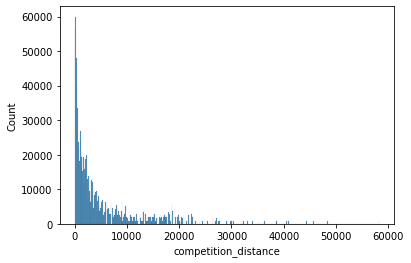

In [23]:
# Numeric atribute view:

# Exploring 'competition_distance'

sns.histplot(df.loc[df['competition_distance']<75000, 'competition_distance']);

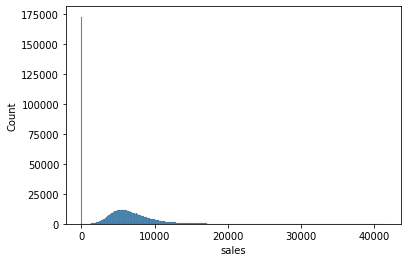

In [24]:
# Numeric atribute view:

# Exploring 'sales'

sns.histplot(df['sales'])

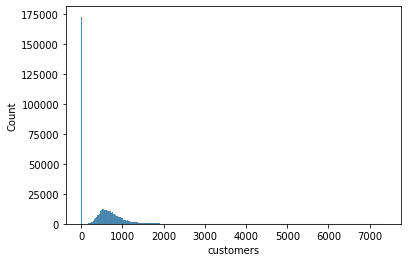

In [25]:
# Numeric atribute view:

# Exploring 'customers'

sns.histplot(df['customers'])

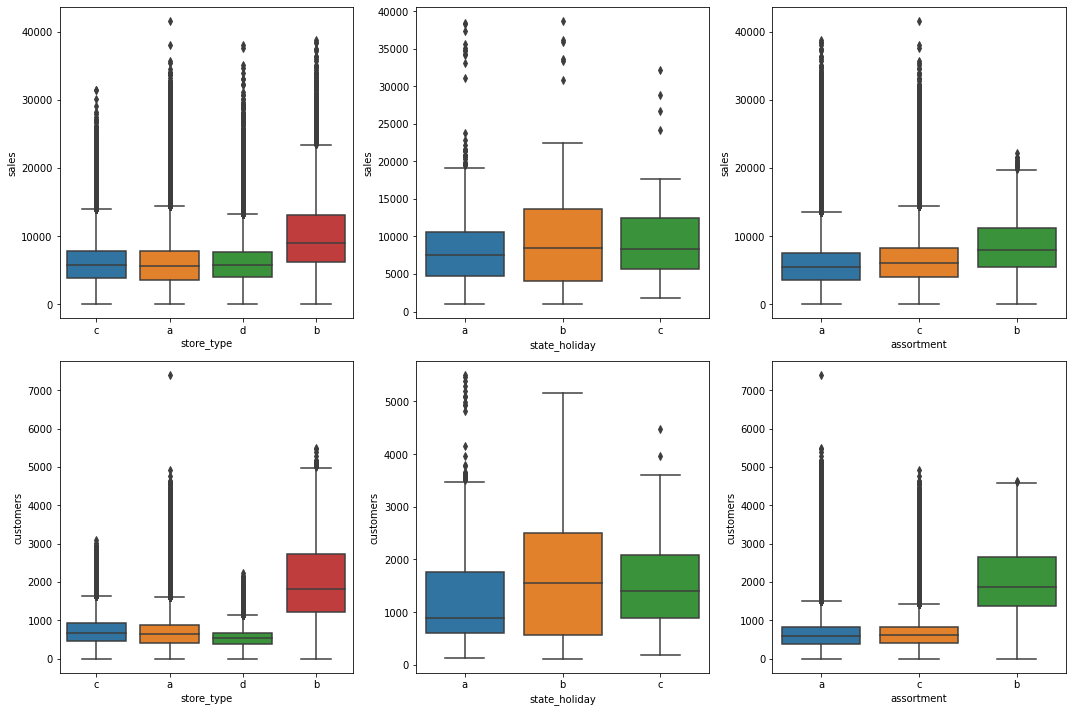

In [26]:
# Categorical atribute view:

plt.figure(figsize=(15,10))

plt.subplot(2,3,1)
sns.boxplot(x=df['store_type'], y=df['sales'], data=df)

plt.subplot(2,3,2)
sns.boxplot(x=df.loc[(df['state_holiday']!='0') & (df['sales']>0), 'state_holiday'], y=df['sales'], data=df)

plt.subplot(2,3,3)
sns.boxplot(x=df['assortment'], y=df['sales'], data=df)



plt.subplot(2,3,4)
sns.boxplot(x=df['store_type'], y=df['customers'], data=df)

plt.subplot(2,3,5)
sns.boxplot(x=df.loc[(df['state_holiday']!='0') & (df['customers']>0), 'state_holiday'], y=df['customers'], data=df)

plt.subplot(2,3,6)
sns.boxplot(x=df['assortment'], y=df['customers'], data=df)



plt.tight_layout()


# Feature engineering

## <font color="#808080">mindmap de hipóteses</font>

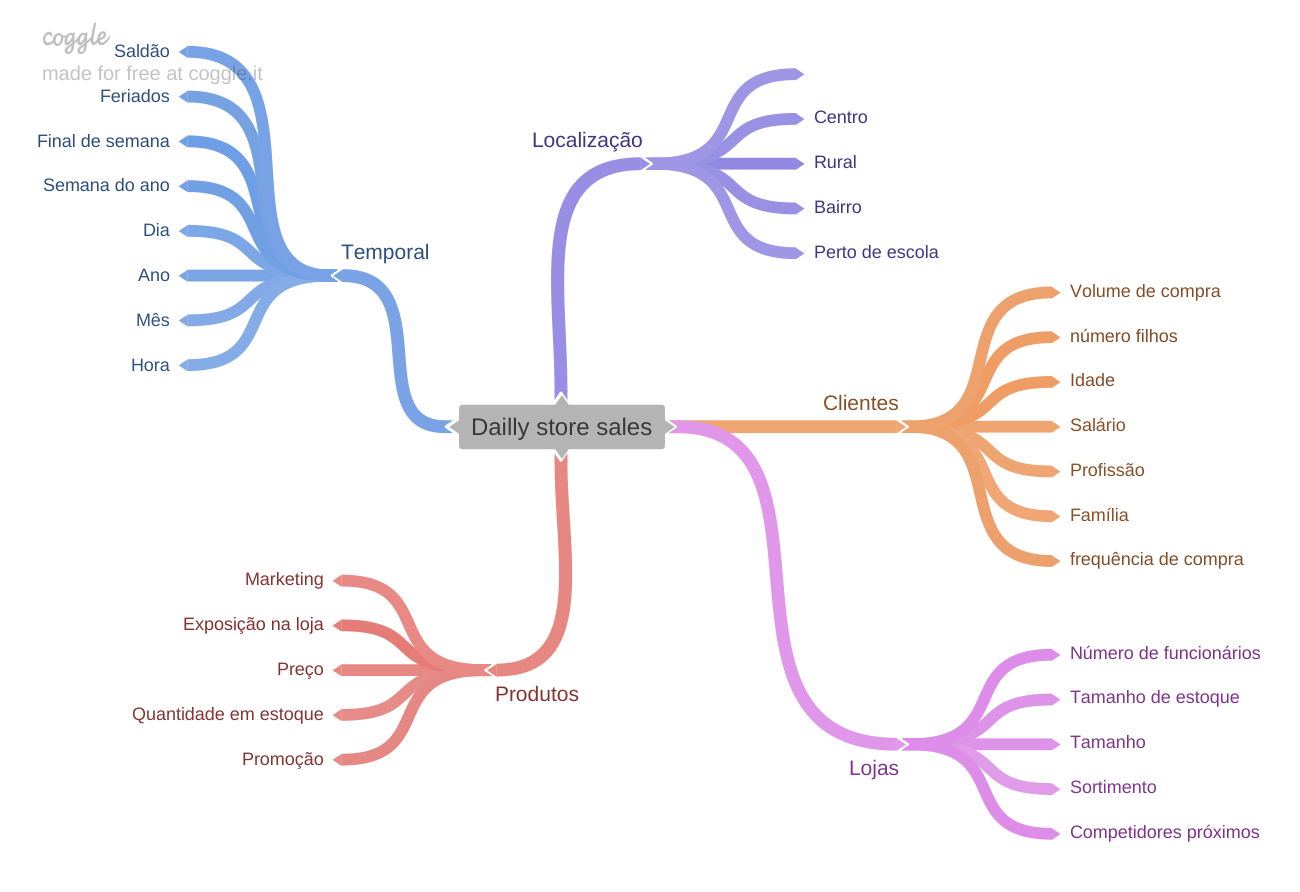

In [ ]:
Image(filename='/home/gustavo/repos/Rossmann/Dailly_store_sales_mindmap.png')

## <font color="#808080">hipóteses à serem validadas com os dados presentes no dataset</font>

 <br></br>
 Nessa parte o mapa mental de hipóteses acima deve ser observado. 
 <br></br>

A partir dos atributos de cada entidade devem ser levantadas as hipóteses que impactam no fenômeno a ser modelado.

LÓGICA: Um aumento/diminuição no atributo x aumenta/diminui a quantidade de vendas.
<br></br>

As hipóteses levantadas são posteriormente validadas a partir dos dados disponíveis no dataset


Dessa forma, baseado nos dados disponíveis no dataset foram levantadas as seguintes hipóteses:
<br></br>

Entidade <em>Loja</em>:


**1.** Lojas com maior sortimentos deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores à mais tempo deveriam vendem mais.
<br></br>

Entidade <em>Produtos</em>:

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**6.** Lojas com mais promoções consecutivas deveriam vender mais.
<br></br>

Entidade <em>Temporal</em>:

**7.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais no segundo semestre do ano.

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**11.** Lojas deveriam vender menos aos finais de semana.

**12.** Lojas deveriam vender menos durante os feriados escolares.

In [27]:
df_1 = df.copy()

In [28]:
# Changing column 'assortment'

df_1['assortment'] = df_1['assortment'].apply(lambda x:'basic' if x=='a' else 'extra' if x=='b' else 'extended')


# Changing column 'state_holiday'

df_1['state_holiday'] = df_1['state_holiday'].apply(lambda x:'Public holiday' if x=='a' else 'Easter' if x=='b' else 'Christmas' if x=='c' else 'regular day')


In [29]:
# Derivando novas variáveis:


# year

df_1['year'] = df_1['date'].dt.year


# month

df_1['month'] = df_1['date'].dt.month


# day

df_1['day'] = df_1['date'].dt.day


# week of year

df_1['week_of_year'] = df_1['date'].dt.weekofyear


# year week
 
df_1['year_week'] = df_1['date'].dt.strftime('%Y-%W') # esse comando apenas coleta a data da venda e muda a formatação




# competition_since (quanto tempo desde o início da competição ate a data da compra)

# 1o passo - juntar as colunas 'competition_open_since_month' com 'competition_open_since_year'

df_1['competition_since'] = df_1[['competition_open_since_year','competition_open_since_month']].apply(lambda x: datetime.datetime(year= x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)

# 2o passo - subtrair as datas de 'date' e 'competition_since' e dividir 30 (granularidade mês)
df_1['competition_time_month'] = ((df_1['date'] - df_1['competition_since'])/ 30).apply(lambda x: x.days).astype(int)




# promo2_since (quanto tempo desde a a promoção estar ativa até a data da compra)

# 1° passo: juntar a coluna 'promo2_since_year' com a coluna 'promo2_since_week' e armazenar em uma nova coluna
df_1['promo2_since'] = df_1.apply(lambda x: str(x['promo2_since_year']) + '-' + str(x['promo2_since_week']),axis=1)

# 2° passo: converter 'promo_since' de string para data
# OBSERVAÇÃO IMPORTANTE: tive que fazer uma adaptação no código.
# no código original a atribuição é feita sobre todas as linhas da coluna 'promo_since', no entanto o lambda
# não estava funcionando na coluna 'promo_since' nas linhas com valores zerados '0-0' (proveniente dos valores
# NA's que foram substituídos por 0 na etapa de preenchimento de NA's) então tive que aplicar a função no df
# filtrado (df_1['promo_since']!='0-0')
df_1.loc[df_1['promo2_since']!='0-0','promo2_since'] = df_1.loc[df_1['promo2_since']!='0-0','promo2_since'].apply(lambda x: datetime.datetime.strptime(x+'-1', '%Y-%W-%w') - datetime.timedelta(days=7) )

# 3° passo: subtrair a data da coluna 'date' da coluna 'promo_since' (criada no passo acima), mantendo o filtro
# condicional de linhas (df_1['promo_since']!='0-0') a atribuindo a uma nova coluna 'promo_time_week' mantendo
# o filtro de linhas
df_1.loc[df_1['promo2_since']!='0-0','promo2_time_week'] = ((df_1.loc[df_1['promo2_since']!='0-0','date'] - df_1.loc[df_1['promo2_since']!='0-0','promo2_since']) / 7).apply(lambda x: x.days).astype(int)

# 4° passo: os filtros de linha anteriores resultaram apenas em dados preenchidos nas linhas do filtro. As linhas
# não pertencentes ao filtro foram preenchidas com NA's. Preencher esses valores com 0
df_1['promo2_time_week'] = df_1['promo2_time_week'].fillna(0)



# Variable filtering and variable selection

<br></br>
<center>Variable filtering x Variable selection</center>
<br></br>

<div align="justify"><b>Variable filtering</b> - eliminação de variáveis baseada nas restrições do negócio.

ex: variáveis que estão disponíveis no dataset de treino mas não estarão em produção, no momento da previsão.
<br></br>

<b>Variable selection</b> - eliminação de variáveis irrelevantes para o aprendizado.

ex: nesse caso serão eliminadas as colunas auxiliares que foram criadas durante a manipulação dos dados</div>
<br></br>
<br></br>

<center>Eliminação de linhas</center>
<br></br>


<div align="justify">Também é importante eliminar as linhas irrelevantes no dataset.
ex: para esse caso serão eliminadas as linhas onde o valor na coluna 'open' é 0 (loja fechada).
As informações de venda nos dias em que a loja está fechada são irrelevantes.
Após essa etapa a coluna 'open' será também eliminada pois ela terá valor constante, sendo irrelevante para o aprendizado de máquina.</div>



## <font color="#808080">Seleção das linhas</font>

In [30]:
df_2 = df_1.copy()

In [31]:
# Quando a loja está fechada ('open'==0) a quantidade de vendas e clientes é 0. Eliminar essas linhas.
# eliminar também as linhas onde não houve vendas (df_2['sales']==0)

df_2 = df_2[(df_2['open']!=0) & (df_2['sales']>0)]

## <font color="#808080">Seleção das colunas</font>

In [32]:
# Eliminar a coluna 'customers' (no momento do modelo em produção a informação sobre a quantidade
# de clientes na loja não estará disponível).
# coluna 'open' estará com valor constante (1 - loja aberta)
# demais colunas são auxiliares

df_2 = df_2.drop(['customers','open','promo_interval','month_map'], axis=1)


# EDA

## <font color="#808080">Análise univariada</font>

### <font color="#808080">Numerical attributes</font>

In [33]:
# Numerical variables

df_2.select_dtypes(include=['float64','int64']).head()

,store,day_of_week,sales,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,competition_time_month,promo2_time_week
0,1,5,5263,1,1,1270.0,9,2008,0,0,0,0,2015,7,31,31,84,0.0
1,2,5,6064,1,1,570.0,11,2007,1,13,2010,1,2015,7,31,31,94,279.0
2,3,5,8314,1,1,14130.0,12,2006,1,14,2011,1,2015,7,31,31,105,226.0
3,4,5,13995,1,1,620.0,9,2009,0,0,0,0,2015,7,31,31,71,0.0
4,5,5,4822,1,1,29910.0,4,2015,0,0,0,0,2015,7,31,31,4,0.0


 <br></br>
 <font size="+2">Histogram: Response variable</font>
 <br></br>

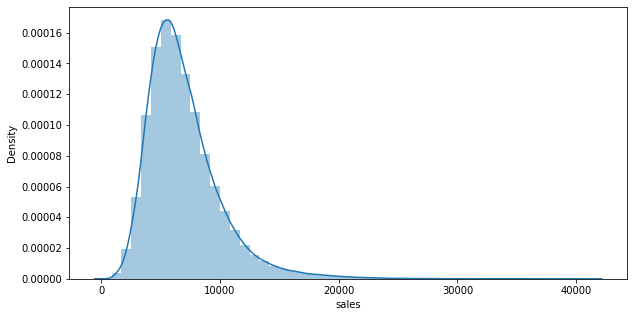

In [34]:
# Response variable distribution

plt.figure(figsize=(10,5))
sns.distplot(df_2['sales']);

<br></br>
<font size="+2">Histogram: numeric attributes</font>
<br></br>

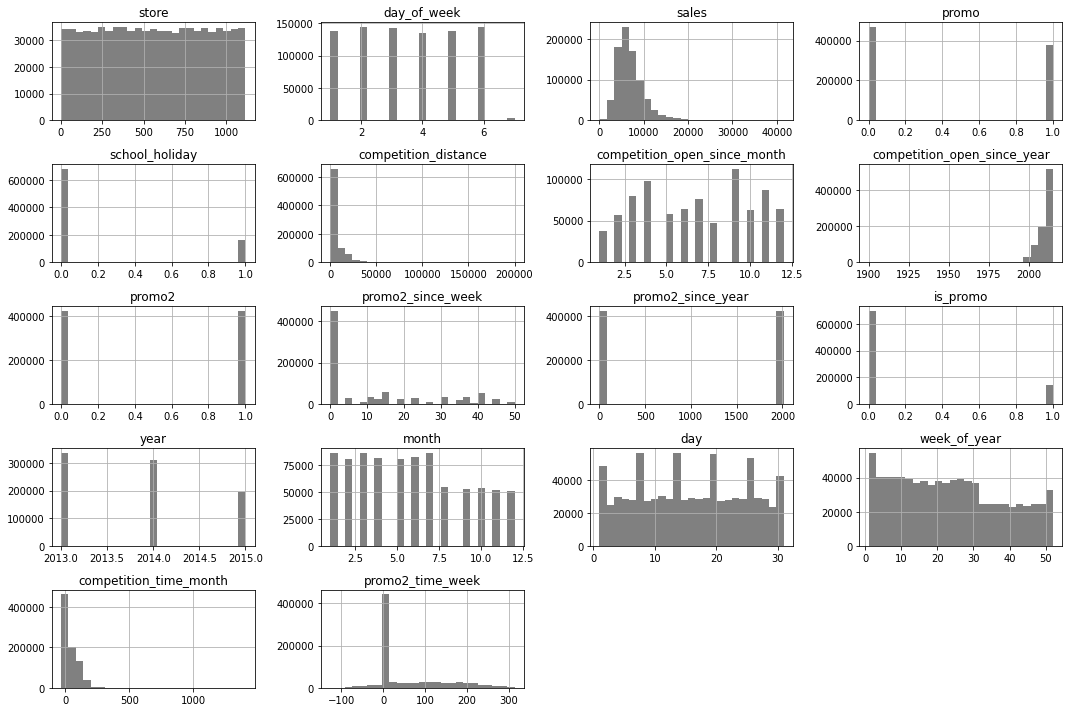

In [35]:
# Numerical attributes distribution

df_2.select_dtypes(include=['float64','int64']).hist(figsize=(15,10), color='grey', bins=25)
plt.tight_layout();

* 'store', 'promo_2' são praticamente constantes não apresentando valores/informação relevante

* 'competition_distance' a maioria dos valores são próximos de zero, indicando que as lojas jão bastante próximas de seus competidores.

* 'day' observa-se picos em intervalos regulares. Possívelmente finais de semana

### <font color="#808080">Categorical attributes</font>

In [36]:
# Selecionando atributos categóricos

df_2.select_dtypes(exclude=['float64','int64','datetime64[ns]']).head()

,state_holiday,store_type,assortment,year_week,promo2_since
0,regular day,c,basic,2015-30,0-0
1,regular day,a,basic,2015-30,2010-03-22 00:00:00
2,regular day,a,basic,2015-30,2011-03-28 00:00:00
3,regular day,c,extended,2015-30,0-0
4,regular day,a,basic,2015-30,0-0


 <br></br>
 <font size="+2">Countplot and Kde plots:</font>
 <br></br>

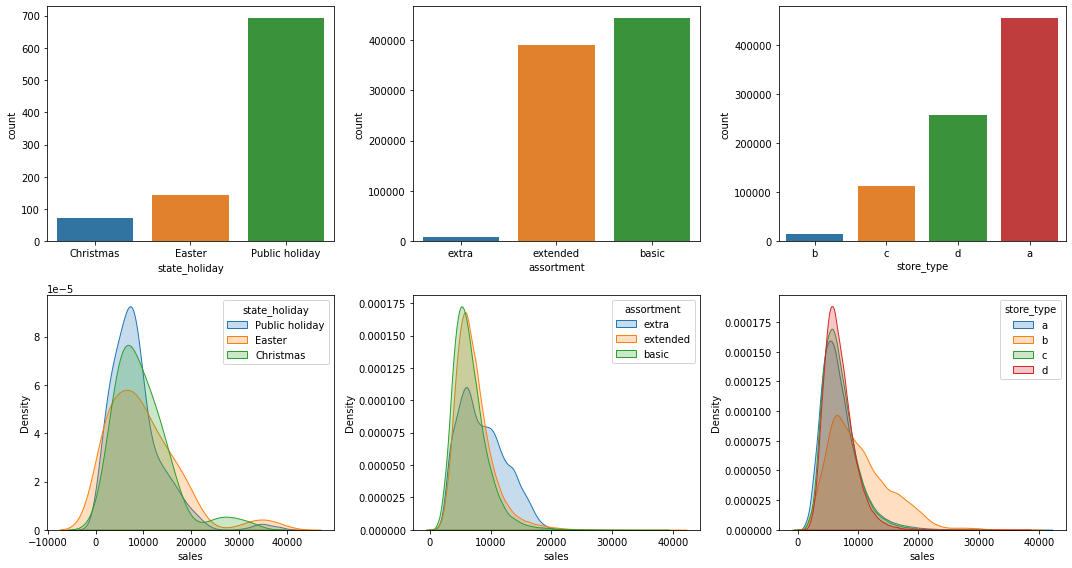

In [37]:
# Countplot


# 'state_holiday'

# nesse plot removi as vendas da categoria 'regular day' pq as vendas eram bem maiores que os demais dias e
## não estava dando para visualizar as vendas dos feriados

plt.figure(figsize=(15,8))

plt.subplot(2,3,1)
sns.countplot(df_2.select_dtypes(exclude=['float64','int64','datetime64[ns]'])['state_holiday'][df_2.select_dtypes(exclude=['float64','int64','datetime64[ns]'])['state_holiday']!='regular day'],
             order = df_2.select_dtypes(exclude=['float64','int64','datetime64[ns]'])['state_holiday'][df_2.select_dtypes(exclude=['float64','int64','datetime64[ns]'])['state_holiday']!='regular day'].value_counts().index[::-1])


# assortment

plt.subplot(2,3,2)
sns.countplot(df_2.select_dtypes(exclude=['float64','int64','datetime64[ns]'])['assortment'],
             order = df_2.select_dtypes(exclude=['float64','int64','datetime64[ns]'])['assortment'].value_counts().index[::-1])


# store_type

plt.subplot(2,3,3)
sns.countplot(df_2.select_dtypes(exclude=['float64','int64','datetime64[ns]'])['store_type'],
             order = df_2.select_dtypes(exclude=['float64','int64','datetime64[ns]'])['store_type'].value_counts().index[::-1])



# Kde plot

# Receita de vendas ('sales') em cada 'state_holiday'

plt.subplot(2,3,4)
sns.kdeplot(df_2[df_2['state_holiday']=='Public holiday']['sales'], 
            label='Public holiday', 
            data = df_2,
            shade=True)

sns.kdeplot(df_2[df_2['state_holiday']=='Easter']['sales'],
            label='Easter',
            data = df_2,
            shade=True)

sns.kdeplot(df_2[df_2['state_holiday']=='Christmas']['sales'],
            label='Christmas',
            data = df_2,
            shade=True)

plt.legend().set_title('state_holiday')


# Receita de vendas ('sales') em cada 'assortment'

plt.subplot(2,3,5)
sns.kdeplot(df_2[df_2['assortment']=='extra']['sales'], 
            label='extra', 
            data = df_2,
            shade=True)

sns.kdeplot(df_2[df_2['assortment']=='extended']['sales'],
            label='extended',
            data = df_2,
            shade=True)

sns.kdeplot(df_2[df_2['assortment']=='basic']['sales'],
            label='basic',
            data = df_2,
            shade=True)

plt.legend().set_title('assortment')


# Receita de vendas ('sales') em cada 'store_type'

plt.subplot(2,3,6)
sns.kdeplot(df_2[df_2['store_type']=='a']['sales'], 
            label='a', 
            data = df_2,
            shade=True)

sns.kdeplot(df_2[df_2['store_type']=='b']['sales'],
            label='b',
            data = df_2,
            shade=True)

sns.kdeplot(df_2[df_2['store_type']=='c']['sales'],
            label='c',
            data = df_2,
            shade=True)

sns.kdeplot(df_2[df_2['store_type']=='d']['sales'],
            label='d',
            data = df_2,
            shade=True)

plt.legend().set_title('store_type')

plt.tight_layout()

## <font color="#808080">Análise bivariada</font>

<br></br>
 <font size="+2">Validação das hipóteses levantadas :</font>
 <br></br>

<font size="+2">- Entidade <i>Loja</i> :</font>

<font size="+1">Hipótese 1:</font>

<b><i>Lojas com maior sortimentos deveriam vender mais.</i></b>

Análise abaixo mostra que a loja com maior sortimento (extra) é a que vende menos enquanto que a loja de sortimento básico é a que vende mais.

Portanto essa afirmação é <font color="red"><b>falsa</b></font>.

Relevância: Relevante.



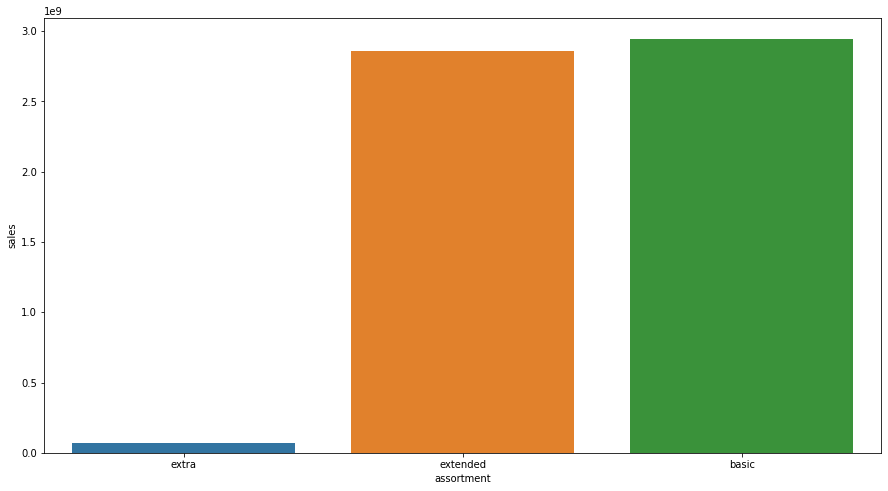

In [38]:
#**1.** Lojas com maior sortimentos deveriam vender mais.


# Barplot soma de vendas

aux1 = df_2[['assortment','sales']].groupby('assortment').sum().reset_index()

plt.figure(figsize=(15,8))


sns.barplot(x=aux1['assortment'],y=aux1['sales'],data=aux1,
           order= df_2[['assortment','sales']].groupby('assortment').sum().sort_values(by='sales').index);



<b><i>As vendas baixas do sortimento 'extra' estariam associados a algum período em específico?</i></b>

O gráfico de linhas abaixo mostra vendas para o sortimento 'extra' abaixo dos demais durante todo o período amostrado.

Uma expansão na região do sortimento 'extra' mostra que embora as vendas sejam menores elas seguem a mesma tendência dos demais sortimentos.

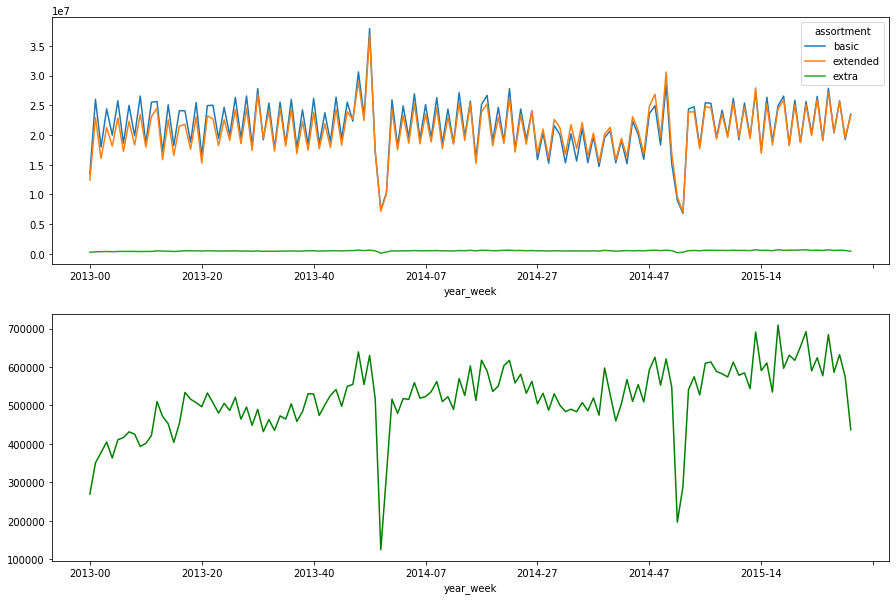

In [39]:
# Será que as vendas baixas do assortimento estão associados a alguma época em específico?

# df_2[['sales','assortment','year_week']].groupby(['year_week','assortment']).sum().reset_index()


# Plot soma de vendas ao longo das semanas do ano por tipo de sortimento

fig, axes = plt.subplots(2,1, figsize=(15,10))

df_2[['sales',
      'assortment',
      'year_week']].groupby(['year_week',
                             'assortment']).sum().reset_index().pivot(index='year_week', 
                                                                      columns='assortment',
                                                                      values='sales').plot(
                                                                                          ax=axes[0])


# Plot soma de vendas ao longo das semanas do ano apenas para tipo de sortimento 'extra'


df_2[['sales',
      'assortment',
      'year_week']].groupby(['year_week',
                             'assortment']).sum().reset_index().pivot(index='year_week', 
                                                                      columns='assortment',
                                                                      values='sales')['extra'].plot(color='green',
                                                                                                   ax=axes[1]);


<font size="+1">Hipótese 2:</font>

<b><i>Lojas com competidores mais próximos deveriam vender menos.</i></b>

Análise abaixo (esquerda) mostra que as maiores quantidades de vendas estão associadas a lojas com competidores mais próximos e a medida em que a distância para o competidor mais próximo aumenta as vendas diminuem. A figura a direta do painel sugere uma correlação negativa entre distância e vendas.

Portanto essa afirmação é <font color="red"><b>falsa</b></font>.

Relevância: Media.



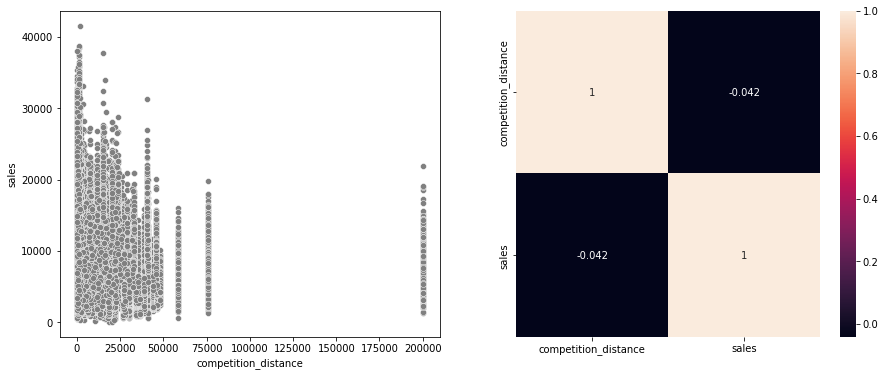

In [40]:
#**2.** Lojas com competidores mais próximos deveriam vender menos.


plt.figure(figsize=(15,6))


# Scatterplot distância competidor X vendas

plt.subplot(1,2,1)
sns.scatterplot(x=df_2['competition_distance'],y=df_2['sales'], color='grey');

# Heatmap de correlação

plt.subplot(1,2,2)
sns.heatmap(df_2[['competition_distance','sales']].corr(), annot=True);

<font size="+1">Hipótese 3:</font>

<b><i>Lojas com competidores à mais tempo deveriam vender mais.</i></b>

A figura abaixo mostra que as competições mais recentes em tempo estão associadas a quantidade de vendas maiores e a medida que o tempo avança a quantidade de vendas diminui.

Portanto essa afirmação é <font color="red"><b>falsa</b></font>.

Relevância: media.



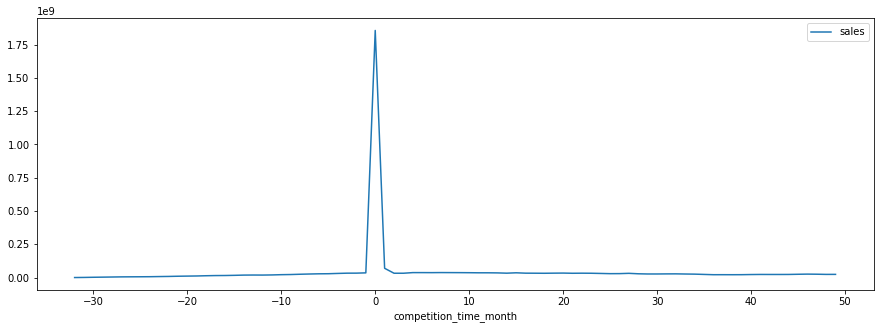

In [41]:
# Vendas em função do tempo de concorrência

df_2[['competition_time_month','sales']].groupby('competition_time_month').sum().reset_index()[(df_2[['competition_time_month','sales']].groupby('competition_time_month').sum().reset_index()['competition_time_month']<50) & (df_2[['competition_time_month','sales']].groupby('competition_time_month').sum().reset_index()['competition_time_month']>-50)].set_index('competition_time_month').plot(figsize=(15,5));

Correlação entre as vendas com o tempo de abertura de uma loja concorrente

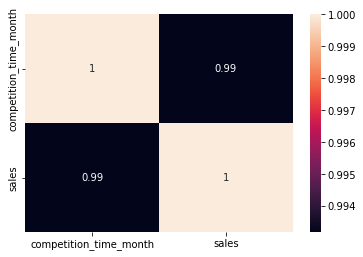

In [42]:
# Correlação entre as vendas com o tempo de abertura de uma loja concorrente

sns.heatmap(df_2[['competition_time_month','sales']].groupby('competition_time_month').sum().reset_index()[df_2[['competition_time_month','sales']].groupby('competition_time_month').sum().reset_index()['competition_time_month']<0].corr(),
           annot=True);

Correlação entre as vendas com o tempo de concorrencia com um concorrente já existente no mercado

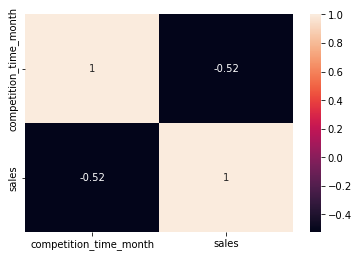

In [43]:
# Correlação entre as vendas com o tempo de concorrencia com um concorrente já existente no mercado

sns.heatmap(df_2[['competition_time_month','sales']].groupby('competition_time_month').sum().reset_index()[df_2[['competition_time_month','sales']].groupby('competition_time_month').sum().reset_index()['competition_time_month']>0].corr(),
           annot=True);

<font size="+2">- Entidade <i>Produtos</i> :</font>

<font size="+1">Hipótese 4:</font>

<b><i>Lojas com promoções ativas por mais tempo deveriam vender mais.</i></b>

Análise abaixo mostra que as vendas são maiores quanto mais próximos do período da promoção extendida elas se encontram.
no gráfico a esquerda (antes da promoção) nota-se que a medida que a data do início da promoção se aproxima a quantidade de vendas aumenta enquanto que no gráfico da direita mostra uma queda de vendas após um certo tempo do início da promoção.

Portanto essa afirmação é <font color="red"><b>falsa</b></font>.

Relevância: Não relevante.



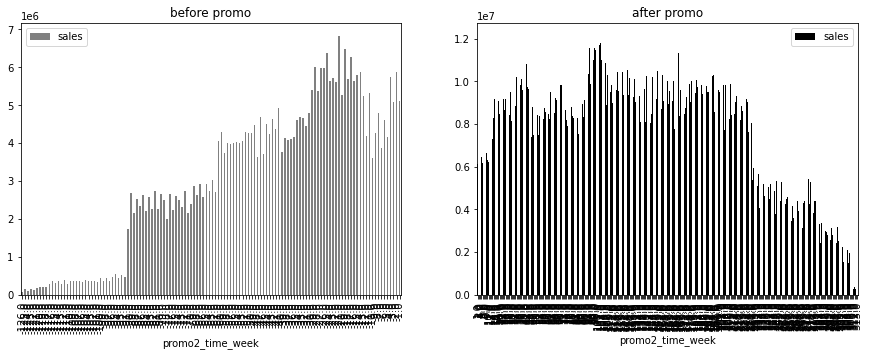

In [44]:
fig, axis = plt.subplots(1,2)


# Antes de a promoção começar

df_2[['promo2_time_week','sales']].groupby('promo2_time_week').sum().reset_index()[df_2[['promo2_time_week','sales']].groupby('promo2_time_week').sum().reset_index()['promo2_time_week']<0].set_index('promo2_time_week').plot(kind='bar',
figsize=(15,5), color='grey', rot=90, ax=axis[0], title='before promo');

# Depois que a promoção começou

df_2[['promo2_time_week','sales']].groupby('promo2_time_week').sum().reset_index()[df_2[['promo2_time_week','sales']].groupby('promo2_time_week').sum().reset_index()['promo2_time_week']>0].set_index('promo2_time_week').plot(kind='bar',
figsize=(15,5), color='black', rot=90, ax=axis[1], title='after promo');




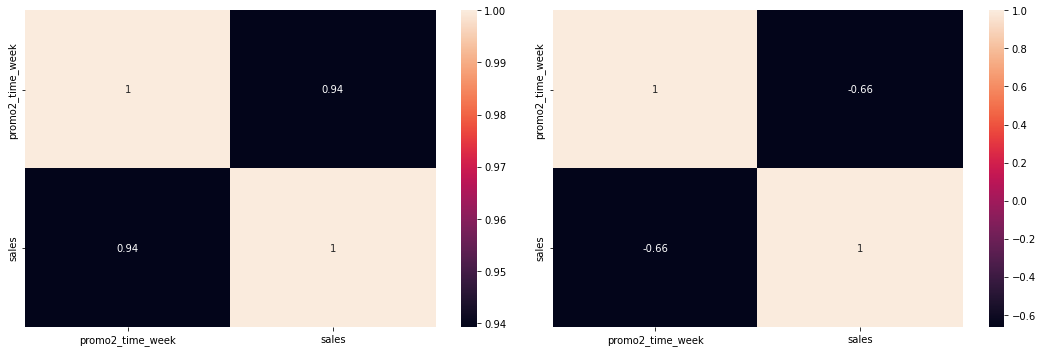

In [45]:
# Antes de a promoção começar - correlação

plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
sns.heatmap(df_2[['promo2_time_week','sales']].groupby('promo2_time_week').sum().reset_index()[df_2[['promo2_time_week','sales']].groupby('promo2_time_week').sum().reset_index()['promo2_time_week']<0].corr(),
           annot=True);

plt.subplot(1,2,2)
# Depois que a promoção começou - correlação

sns.heatmap(df_2[['promo2_time_week','sales']].groupby('promo2_time_week').sum().reset_index()[df_2[['promo2_time_week','sales']].groupby('promo2_time_week').sum().reset_index()['promo2_time_week']>0].corr(),
           annot=True);

plt.tight_layout()

<font size="+1">Hipótese 5:</font>

<s><b><i>Lojas com mais dias de promoção deveriam vender mais.</i></b></s>

Essa hipótese será validada no próximo ciclo do CRISP desse projeto.



<font size="+1">Hipótese 6:</font>

<b><i>Lojas com mais promoções consecutivas deveriam vender mais.</i></b>

Análise do gráfico de barras abaixo mostra que o maior volume de vendas é correspondente a promo, sem que acha uma continuidade com promo2. O gráfico de linhas abaixo mostra que ao longo do tempo tanto o perfil quanto a quantidade de vendas da promo é semelhante as vendas de promo+promo2

Portanto essa afirmação é <font color="red"><b>falsa</b></font>.

Relevância: pouco relevante.



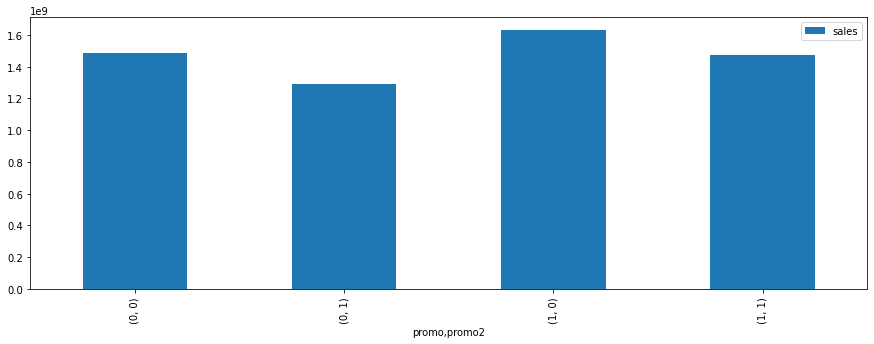

In [46]:
df_2.loc[:,['promo','promo2','sales']].groupby(['promo','promo2']).sum().plot(kind='bar', figsize=(15,5));

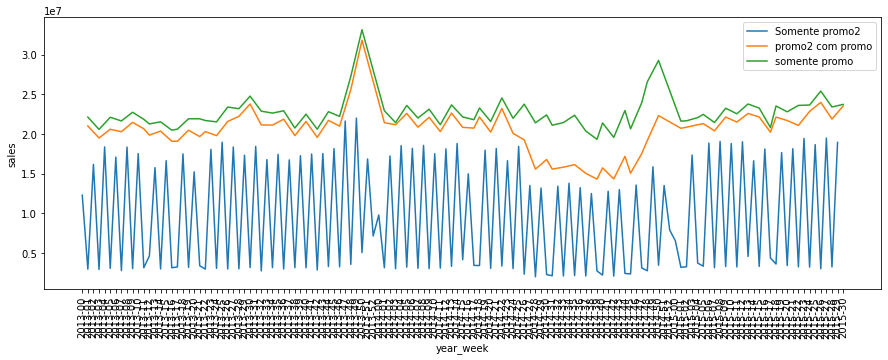

In [47]:
# Comparação efeito nas vendas da segunda promoção quando se faz ou não a primeira


plt.figure(figsize=(15,5))

#Somente promo2 (0,1)
sns.lineplot(
    data=df_2[(df_2['promo']==0) & (df_2['promo2']==1)][['year_week','sales']].groupby('year_week').sum().reset_index(),
    y='sales',
    x='year_week')


# promo2 seguida da promo (1,1)
sns.lineplot(
    data=df_2[(df_2['promo']==1) & (df_2['promo2']==1)][['year_week','sales']].groupby('year_week').sum().reset_index(),
    y='sales',
    x='year_week')


# promo sem promo2 (1,0)
sns.lineplot(
    data=df_2[(df_2['promo']==1) & (df_2['promo2']==0)][['year_week','sales']].groupby('year_week').sum().reset_index(),
    y='sales',
    x='year_week')

plt.xticks(rotation=90)


plt.legend(labels=['Somente promo2','promo2 com promo','somente promo']);

<font size="+2">- Entidade <i>Temporal</i> :</font>

<font size="+1">Hipótese 7:</font>

<b><i>Lojas abertas durante o feriado de Natal deveriam vender mais..</i></b>

Análise abaixo mostra que, na primeira figura do painel, no geral a a soma de vendas de feriados públicos é maior. Esse comportamento é razoável pois essas vendas são referentes a todos os feriados (que não são Páscoa e nem Natal) somados. O segundo painel mostra que esse comportamento se mantém ao longo dos anos avaliados. O Natal de 2015 não foi incluído porque o ano ainda não estava fechado no dataset avaliado.

Já o terceiro painel mostra a média de vendas. Embora o valor absoluto de vendas no Natal seja menor, o Natal é o feriado que possui a maior média de vendas dentro do período avaliado

Portanto essa afirmação é <font color="red"><b>falsa</b></font>.

Relevância: Relevante.



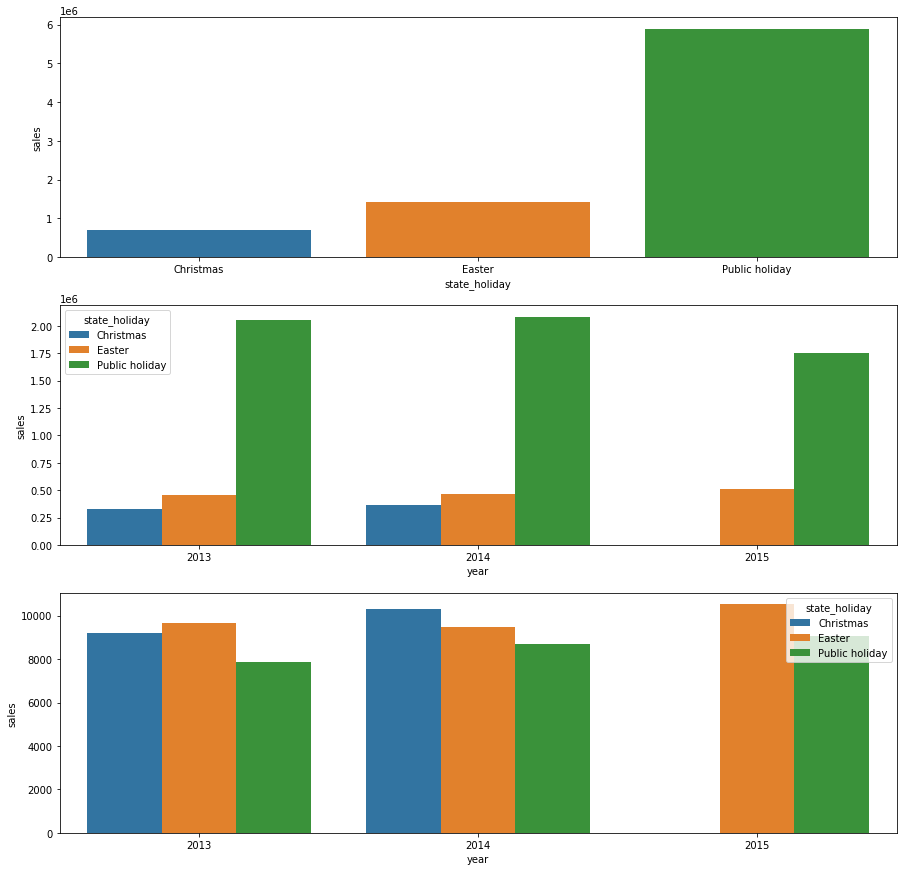

In [48]:

# Vendas nos feriados (foi removido 'regular_day' para facilitar a comparação)

plt.figure(figsize=(15,15))

plt.subplot(3,1,1)
sns.barplot(data=df_2.loc[df_2['state_holiday']!='regular day',['state_holiday','sales']].groupby('state_holiday').sum().reset_index(),
           x='state_holiday',
           y='sales');


# Vendas nos feriados ao longo dos anos

plt.subplot(3,1,2)
sns.barplot(data=df_2.loc[df_2['state_holiday']!='regular day',['state_holiday','year','sales']].groupby(['year','state_holiday']).sum().reset_index(),
           x='year',
           y='sales', hue='state_holiday');


# Média de Vendas nos feriados ao longo dos anos

plt.subplot(3,1,3)
sns.barplot(data=df_2.loc[df_2['state_holiday']!='regular day',['state_holiday','year','sales']].groupby(['year','state_holiday']).mean().reset_index(),
           x='year',
           y='sales', hue='state_holiday');

<font size="+1">Hipótese 8:</font>

<b><i>Lojas deveriam vender mais ao longo dos anos.</i></b>

Análise abaixo mostra que, para o período avaliado houve uma tendência de queda das vendas. Embora o ano de 2015 não seja um ano fechado, a observação leva a crer que a tendência será mantida no fechamento do ano.

Portanto essa afirmação é <font color="red"><b>falsa</b></font>.

Relevância: Relevante.



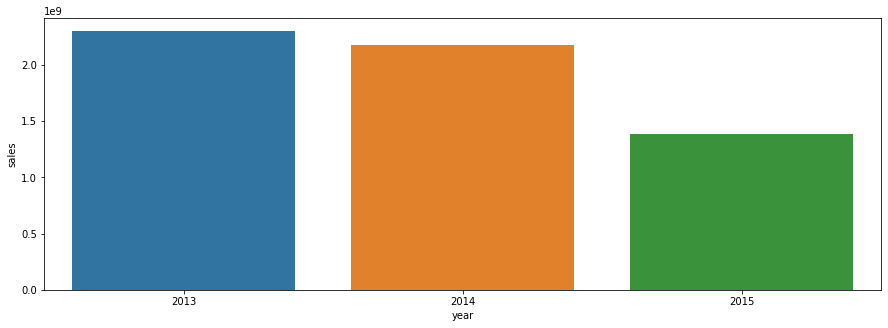

In [49]:
plt.figure(figsize=(15,5))

sns.barplot(data=df_2[['year','sales']].groupby('year').sum().reset_index(),
            x='year',
            y='sales');

<font size="+1">Hipótese 9:</font>

<b><i>Lojas deveriam vender mais no segundo semestre do ano.</i></b>

Análise abaixo mostra que, do sexto mês do ano em diante existe uma tendência de queda nas vendas (painel da esquerda). A análise de correlação (painel direita) mostra um valor de -0.75 sugerindo uma correlação forte entre o aumento dos meses com a queda das vendas.

O painel abaixo mostra os meses para cada ano, entretanto não foi possível obter um padrão evidente.

Portanto essa afirmação é <font color="red"><b>falsa</b></font>.

Relevância: Relevante.



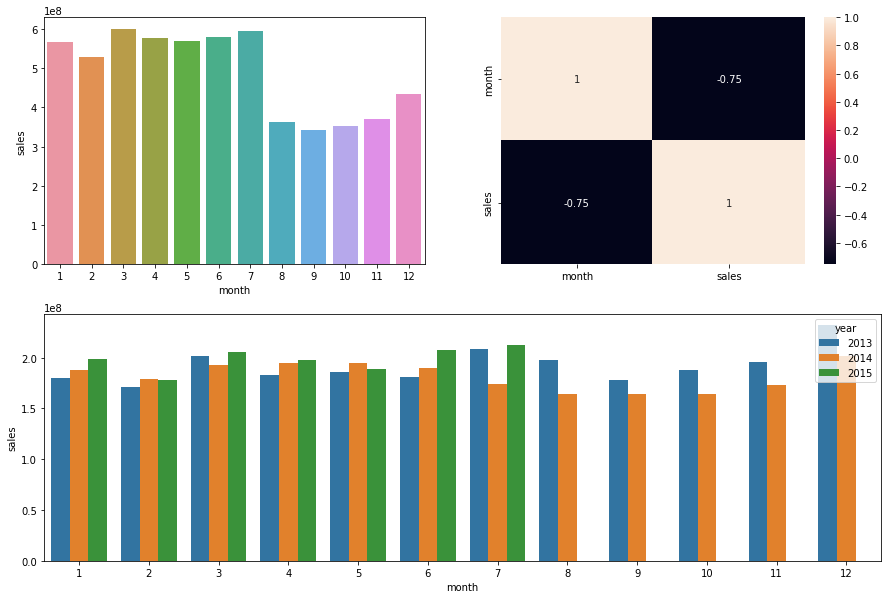

In [50]:
plt.figure(figsize=(15,10))

plt.subplot(2,2,1)
sns.barplot(data=df_2[['month','sales']].groupby(['month']).sum().reset_index(),
            x='month',
            y='sales');

plt.subplot(2,2,2)
sns.heatmap(data=df_2[['month','sales']].groupby(['month']).sum().reset_index().corr(),
           annot=True);

plt.subplot(2,1,2)
sns.barplot(data=df_2[['month','year','sales']].groupby(['month','year']).sum().reset_index(),
            x='month',
            y='sales',
           hue='year');

<font size="+1">Hipótese 10:</font>

<b><i>Lojas deveriam vender mais depois do dia 10 de cada mês.</i></b>

Análise abaixo mostra que, o total de vendas depois do dia 10 é maior do que o total de vendas antes do dia 10 (painel superior).

Ao desmembrar as velas antes e depois do dia 10 por cada ano avaliado o comportamento se mantém embora a diferença seja mais sutil.

Portanto essa afirmação é <font color="red"><b>falsa</b></font>.

Relevância: Relevante.



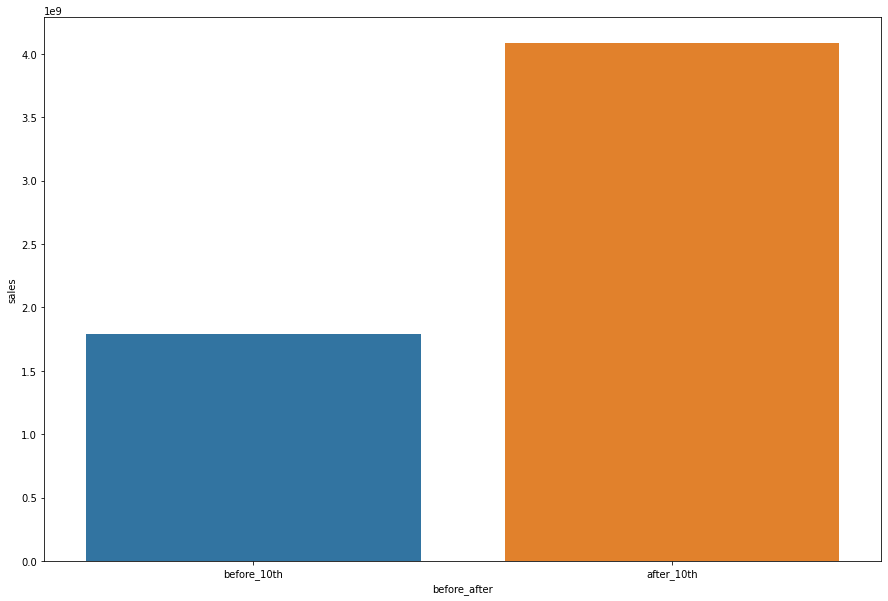

In [51]:
aux = df_2[['day','sales']].groupby(['day']).sum().reset_index()

aux['before_after'] = aux['day'].apply(lambda x:'before_10th' if x<10 else 'after_10th')

aux_1 = df_2[['day','year','sales']].groupby(['day','year']).sum().reset_index()

aux_1['before_after'] = aux_1['day'].apply(lambda x:'before_10th' if x<10 else 'after_10th')

plt.figure(figsize=(15,10))



sns.barplot(data=aux[['before_after','sales']].groupby('before_after').sum().reset_index(),
            x='before_after',
            y='sales',
           order=aux[['before_after','sales']].groupby('before_after').sum().reset_index().sort_values(by='sales')['before_after']);


<font size="+1">Hipótese 11:</font>

<b><i>Lojas deveriam vender menos aos finais de semana.</i></b>

Análise abaixo mostra que, aos finais de semana a quantidade de vendas diminui.

Portanto essa afirmação é <font color="green"><b>verdadeira</b></font>.

Relevância: Relevante.



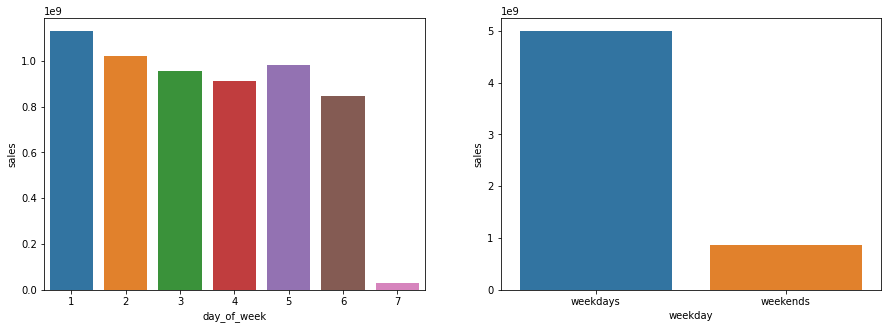

In [52]:

plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
sns.barplot(data=df_2[['day_of_week','sales']].groupby('day_of_week').sum().reset_index(),
            x='day_of_week',
            y='sales');


aux = df_2[['day_of_week','sales']].groupby('day_of_week').sum().reset_index()

aux['weekday'] = aux['day_of_week'].apply(lambda x: 'weekdays' if x<6 else 'weekends')

plt.subplot(1,2,2)
sns.barplot(data=aux[['weekday','sales']].groupby('weekday').sum().reset_index(),
            x='weekday',
            y='sales');

<font size="+1">Hipótese 12:</font>

<b><i>Lojas deveriam vender menos durante os feriados escolares..</i></b>

Análise abaixo mostra que, no geral, nos feriados escolares a venda é menor quando comparada a períodos sem feriados escolares. Uma ressalva fica para a análise mês a mês (painel da direita) que mostra uma crescente nas vendas no mês 7 e no mês 8 as vendas nos dias de feriado escolar superando os demais dias, possívelmente o comportamento destoante desses meses é explicado pelo período de férias escolares.

Portanto essa afirmação é <font color="green"><b>verdadeira</b></font>.

Relevância: Relevante.



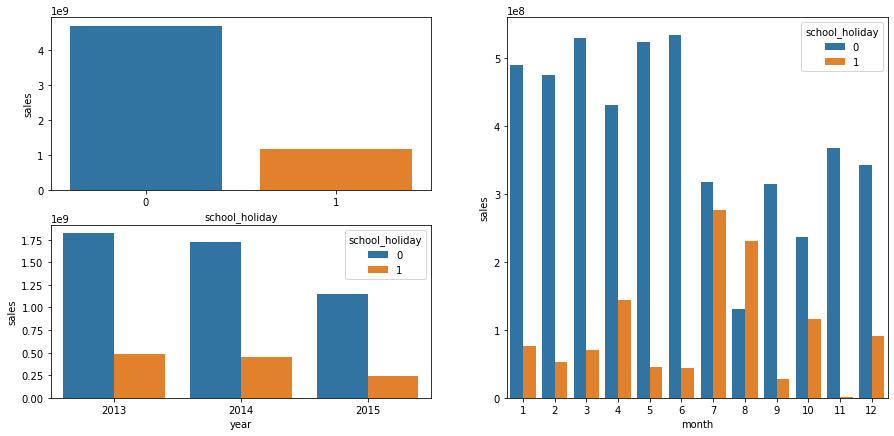

In [53]:
plt.figure(figsize=(15,7))


plt.subplot(2,2,1)
sns.barplot(data=df_2[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index(),
            x='school_holiday',
            y='sales');

plt.subplot(2,2,3)
sns.barplot(data=df_2[['school_holiday', 'year', 'sales']].groupby(['school_holiday','year']).sum().reset_index(),
            x='year',
            y='sales', hue='school_holiday');

plt.subplot(1,2,2)
sns.barplot(data=df_2[['school_holiday', 'month', 'sales']].groupby(['school_holiday','month']).sum().reset_index(),
            x='month',
            y='sales', hue='school_holiday');

In [54]:
# Conclusões

tab = [['Hipótese', 'Conclusão', 'Relevância'],
      ['H1', 'False','Baixa'],
      ['H2', 'False','Relevante'],
      ['H3', 'False','Relevante'],
      ['H4', 'False','Não relevante'],
      ['H5', '-','-'],
      ['H6', 'False','Pouco relevante'],
      ['H7', 'False','Relevante'],
      ['H8', 'False','Relevante'],
      ['H9', 'False','Relevante'],
      ['H10', 'Verdadeira','Relevante'],
      ['H11', 'Verdadeira','Relevante'],
      ['H12', 'Verdadeira','Relevante'],]

print(tabulate(tab, headers='firstrow'))

Hipótese    Conclusão    Relevância
----------  -----------  ---------------
H1          False        Baixa
H2          False        Relevante
H3          False        Relevante
H4          False        Não relevante
H5          -            -
H6          False        Pouco relevante
H7          False        Relevante
H8          False        Relevante
H9          False        Relevante
H10         Verdadeira   Relevante
H11         Verdadeira   Relevante
H12         Verdadeira   Relevante


## <font color="#808080">Análise multivariada</font>

* Heatmap de correlação das variáveis numéricas (dataset com os features derivados):

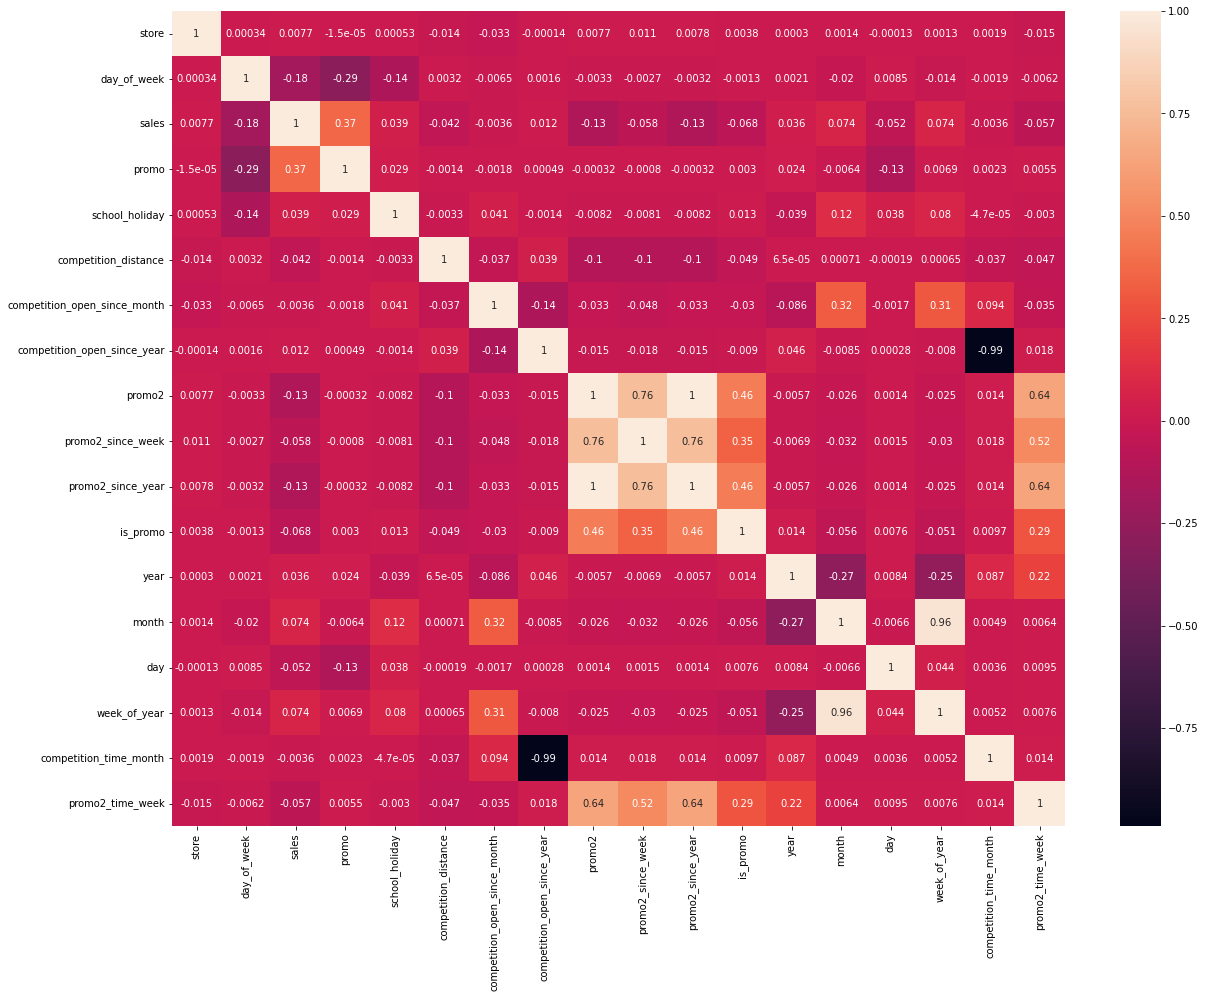

In [55]:
# Heatmap de correlação das variáveis numéricas (dataset com os features derivados)


plt.figure(figsize=(20,15))

sns.heatmap(df_2.select_dtypes(include=['float64','int64']).corr(), annot=True);

* Heatmap de correlação das variáveis numéricas (dataset original):

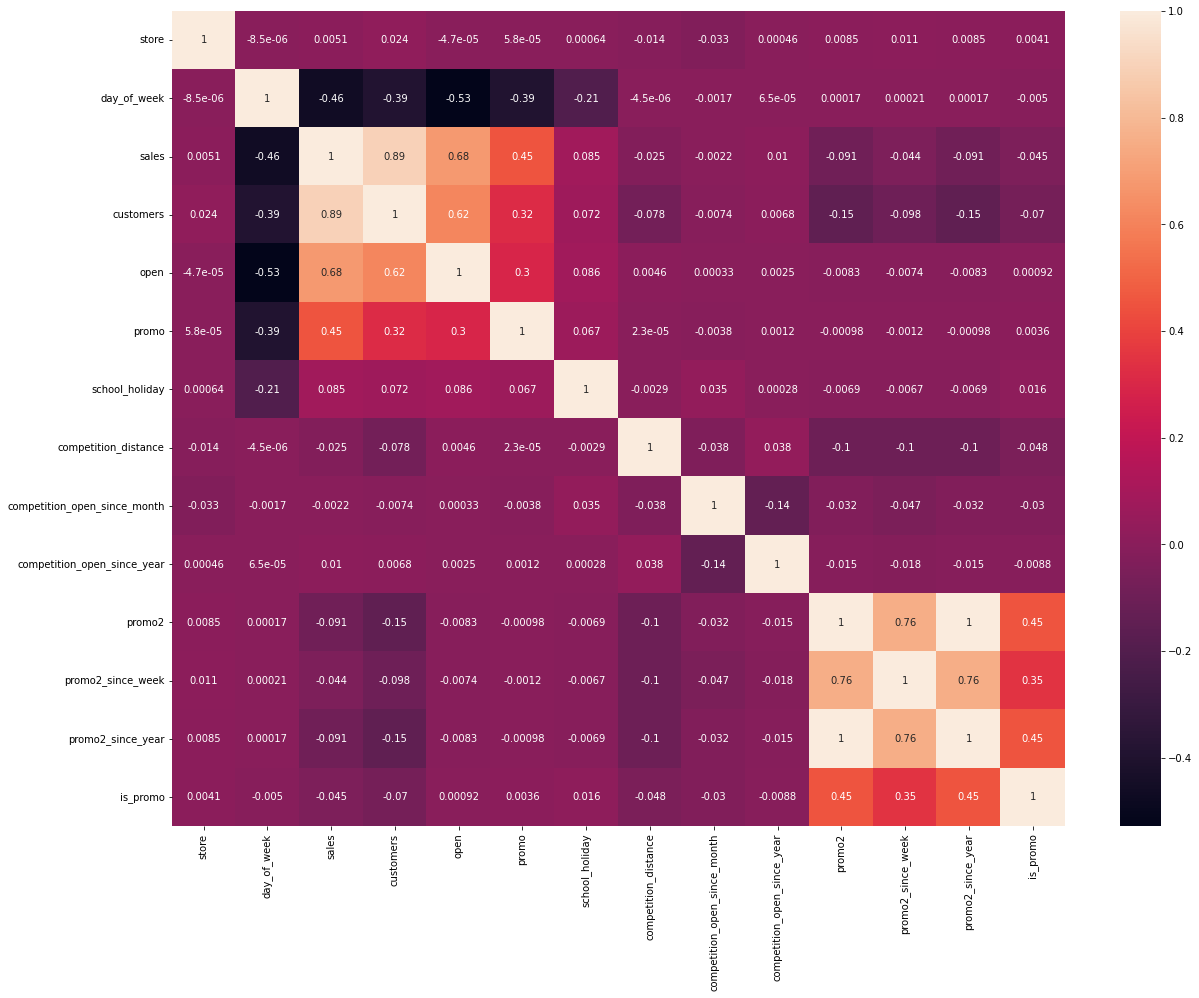

In [56]:
# Heatmap de correlação das variáveis numéricas (dataset original)

plt.figure(figsize=(20,15))

sns.heatmap(num_attrib.corr(), annot=True);

* Heatmap de correlação das variáveis categóricas:

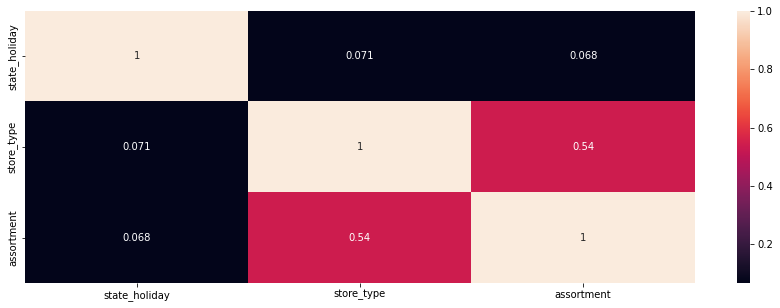

In [57]:
# Heatmap de correlação das variáveis categóricas

plt.figure(figsize=(15,5))
plot_corr(df_2, ['state_holiday','store_type','assortment'] );

# Data preparation

## <font color="#808080">Train/Test split</font>

O split deve ser feito antes da preparação dos dados para evitar data leekage.

In [58]:
df_3 = df_2.copy()

In [59]:
# Train test split

# Dados temporais: split é feito em passado (treino) futuro (teste)
# como o modelo será construído para fazer previsão de 6 dias o conjunto será dividido com os 6
# semanas dias do dataset

df_3[['store','date']].groupby('store').min() # verificando a menor data para cada store no dataset

df_3[['store', 'date']].groupby('store').max() # verificando a menor data para cada store no dataset

,date
store,
1,2015-07-31
2,2015-07-31
3,2015-07-31
4,2015-07-31
5,2015-07-31
...,...
1111,2015-07-31
1112,2015-07-31
1113,2015-07-31


In [60]:
df_3[['store', 'date']].groupby('store').max().reset_index()['date'][0] # Obtendo o primeiro valor da maior data


# Subtrair 6 semanas da maior data (método datetime.timedelta)

df_3[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days=7*6)

Timestamp('2015-06-19 00:00:00')

In [61]:
# Separando em treino/teste

#train
X_train = df_3.loc[df_3['date']<'2015-06-19 00:00:00', df_3.columns!='sales']
y_train = df_3.loc[df_3['date']<'2015-06-19 00:00:00', 'sales']

#test
X_test = df_3.loc[df_3['date']>='2015-06-19 00:00:00', df_3.columns!='sales']
y_test = df_3.loc[df_3['date']>='2015-06-19 00:00:00', 'sales']

In [62]:

print('\nInformações dos dados:\n')
print('Mínimo conjunto treino: {0}'.format(X_train['date'].min()))
print('Máximo conjunto treino: {0}'.format(X_train['date'].max()))
print('\n')
print('Mínimo conjunto teste: {0}'.format(X_test['date'].min()))
print('Máximo conjunto teste: {0}'.format(X_test['date'].max()))



Informações dos dados:

Mínimo conjunto treino: 2013-01-01 00:00:00
Máximo conjunto treino: 2015-06-18 00:00:00


Mínimo conjunto teste: 2015-06-19 00:00:00
Máximo conjunto teste: 2015-07-31 00:00:00


## <font color="#808080">Scaling - variáveis numéricas</font>

In [63]:
X_train.select_dtypes(include=['float64','int64']).head()

,store,day_of_week,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,competition_time_month,promo2_time_week
47945,1,4,1,0,1270.0,9,2008,0,0,0,0,2015,6,18,25,82,0.0
47946,2,4,1,0,570.0,11,2007,1,13,2010,0,2015,6,18,25,92,273.0
47947,3,4,1,0,14130.0,12,2006,1,14,2011,0,2015,6,18,25,104,220.0
47948,4,4,1,0,620.0,9,2009,0,0,0,0,2015,6,18,25,70,0.0
47949,5,4,1,0,29910.0,4,2015,0,0,0,0,2015,6,18,25,2,0.0


In [64]:
# Atributos numéricos escolhidos para o scaling:


# competition_distance (Robust Scaler)
 
# year (MinMax Scaler)

# competition_time_month (Robust Scaler)
 
# promo2_time_week (MinMax Scaler)

In [65]:

# Para decidir entre MinMaxScaler e RobustScaler os boxplots das variáveis foram inspecionados.
# para variáveis com outiliers escolheu-se o Robust Scaler e para as demais o MinMax Scaler


# Scaling com Robust Scaler ('competition_distance' e 'competition_time_month')

X_train['competition_distance'], X_train['competition_time_month'] = [RobustScaler().fit_transform(X_train[[i]].values) for i in ['competition_distance', 'competition_time_month']]


# Scaling com MinMax Scaler ('year' e 'promo2_time_week')

X_train['year'], X_train['promo2_time_week'] = [MinMaxScaler().fit_transform(X_train[[i]].values) for i in ['year', 'promo2_time_week']]



In [66]:
# Fazendo o scaling para o X_test

# Scaling com Robust Scaler ('competition_distance' e 'competition_time_month')

X_test['competition_distance'], X_test['competition_time_month'] = [RobustScaler().fit_transform(X_test[[i]].values) for i in ['competition_distance', 'competition_time_month']]


# Scaling com MinMax Scaler ('year' e 'promo2_time_week')

X_test['year'], X_test['promo2_time_week'] = [MinMaxScaler().fit_transform(X_test[[i]].values) for i in ['year', 'promo2_time_week']]

## <font color="#808080">Encoding - variáveis categóricas</font>

In [67]:
X_train.select_dtypes(exclude=['float64','int64','datetime64[ns]']).head()

,state_holiday,store_type,assortment,year_week,promo2_since
47945,regular day,c,basic,2015-24,0-0
47946,regular day,a,basic,2015-24,2010-03-22 00:00:00
47947,regular day,a,basic,2015-24,2011-03-28 00:00:00
47948,regular day,c,extended,2015-24,0-0
47949,regular day,a,basic,2015-24,0-0


In [68]:
# state_holiday (One-Hot encoding)

X_train = pd.get_dummies(data=X_train, columns=['state_holiday'], prefix=['state_holiday'])




# store_type (Label encoder)

X_train['store_type'] = LabelEncoder().fit_transform(X_train['store_type'])



# assortment (Ordinal Encoder)

assortment_encoding_map = {'basic': 1, 'extended':2, 'extra':3}

X_train['assortment'] = X_train['assortment'].map(assortment_encoding_map)

In [69]:
X_train.head()

,store,day_of_week,date,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo2_since,promo2_time_week,state_holiday_Christmas,state_holiday_Easter,state_holiday_Public holiday,state_holiday_regular day
47945,1,4,2015-06-18,1,0,2,1,-0.170968,9,2008,0,0,0,0,1.0,6,18,25,2015-24,2008-09-01,0.904110,0-0,0.290993,0,0,0,1
47946,2,4,2015-06-18,1,0,0,1,-0.283871,11,2007,1,13,2010,0,1.0,6,18,25,2015-24,2007-11-01,1.041096,2010-03-22 00:00:00,0.921478,0,0,0,1
47947,3,4,2015-06-18,1,0,0,1,1.903226,12,2006,1,14,2011,0,1.0,6,18,25,2015-24,2006-12-01,1.205479,2011-03-28 00:00:00,0.799076,0,0,0,1
47948,4,4,2015-06-18,1,0,2,2,-0.275806,9,2009,0,0,0,0,1.0,6,18,25,2015-24,2009-09-01,0.739726,0-0,0.290993,0,0,0,1
47949,5,4,2015-06-18,1,0,0,1,4.448387,4,2015,0,0,0,0,1.0,6,18,25,2015-24,2015-04-01,-0.191781,0-0,0.290993,0,0,0,1


In [70]:
# Encoding do conjunto teste

# state_holiday (One-Hot encoding)

X_test = pd.get_dummies(data=X_test, columns=['state_holiday'], prefix=['state_holiday'])




# store_type (Label encoder)

X_test['store_type'] = LabelEncoder().fit_transform(X_test['store_type'])



# assortment (Ordinal Encoder)

assortment_encoding_map = {'basic': 1, 'extended':2, 'extra':3}

X_test['assortment'] = X_test['assortment'].map(assortment_encoding_map)

In [71]:
X_test.head()

,store,day_of_week,date,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo2_since,promo2_time_week,state_holiday_regular day
0,1,5,2015-07-31,1,1,2,1,-0.171244,9,2008,0,0,0,0,0.0,7,31,31,2015-30,2008-09-01,0.584270,0-0,0.000000,1
1,2,5,2015-07-31,1,1,0,1,-0.284330,11,2007,1,13,2010,1,0.0,7,31,31,2015-30,2007-11-01,0.696629,2010-03-22 00:00:00,0.891374,1
2,3,5,2015-07-31,1,1,0,1,1.906300,12,2006,1,14,2011,1,0.0,7,31,31,2015-30,2006-12-01,0.820225,2011-03-28 00:00:00,0.722045,1
3,4,5,2015-07-31,1,1,2,2,-0.276252,9,2009,0,0,0,0,0.0,7,31,31,2015-30,2009-09-01,0.438202,0-0,0.000000,1
4,5,5,2015-07-31,1,1,0,1,4.455574,4,2015,0,0,0,0,0.0,7,31,31,2015-30,2015-04-01,-0.314607,0-0,0.000000,1


## <font color="#808080">Transformação - variável alvo</font>

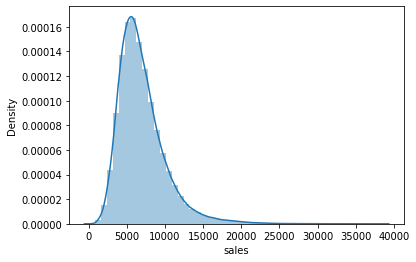

In [72]:
# Distribuição da variável alvo antes da transformação

sns.distplot(y_train)

In [73]:
# Transformação log da variável alvo

y_train = np.log1p(y_train)

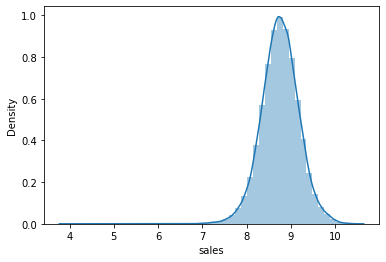

In [74]:
# Distribuição da variável alvo depois da transformação

sns.distplot(y_train)

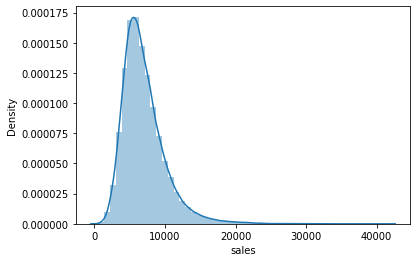

In [75]:
# Conjunto teste antes da transformação

sns.distplot(y_test)

In [76]:
# Transformação log da variável alvo - Conjunto teste

y_test = np.log1p(y_test)

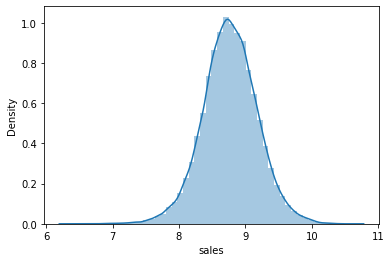

In [77]:
# Distribuição da variável alvo depois da transformação - Conjunto teste

sns.distplot(y_test)

## <font color="#808080">Transformação de natureza - variáveis de natureza cíclica</font>

In [78]:
# Atributos de natureza cíclica:

# day_of_week

# month

# day

# week_of_year

In [79]:
# Transformando os atributos

# day

X_train['day_sin'] = X_train['day'].apply(lambda x: np.sin(x*(2.*np.pi/30))) 
X_train['day_cos'] = X_train['day'].apply(lambda x: np.cos(x*(2.*np.pi/30)))

# day_of_week

X_train['day_of_week_sin'] = X_train['day_of_week'].apply(lambda x: np.sin(x*(2.*np.pi/7)))
X_train['day_of_week_cos'] = X_train['day_of_week'].apply(lambda x: np.cos(x*(2.*np.pi/7)))


# month

X_train['month_sin'] = X_train['month'].apply(lambda x: np.sin(x*(2.*np.pi/12)))
X_train['month_cos'] = X_train['month'].apply(lambda x: np.cos(x*(2.*np.pi/12)))


# week_of_year

X_train['week_of_year_sin'] = X_train['week_of_year'].apply(lambda x: np.sin(x*(2.*np.pi/52)))
X_train['week_of_year_cos'] = X_train['week_of_year'].apply(lambda x: np.cos(x*(2.*np.pi/52)))

In [80]:
X_train.head()

,store,day_of_week,date,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo2_since,promo2_time_week,state_holiday_Christmas,state_holiday_Easter,state_holiday_Public holiday,state_holiday_regular day,day_sin,day_cos,day_of_week_sin,day_of_week_cos,month_sin,month_cos,week_of_year_sin,week_of_year_cos
47945,1,4,2015-06-18,1,0,2,1,-0.170968,9,2008,0,0,0,0,1.0,6,18,25,2015-24,2008-09-01,0.904110,0-0,0.290993,0,0,0,1,-0.587785,-0.809017,-0.433884,-0.900969,1.224647e-16,-1.0,0.120537,-0.992709
47946,2,4,2015-06-18,1,0,0,1,-0.283871,11,2007,1,13,2010,0,1.0,6,18,25,2015-24,2007-11-01,1.041096,2010-03-22 00:00:00,0.921478,0,0,0,1,-0.587785,-0.809017,-0.433884,-0.900969,1.224647e-16,-1.0,0.120537,-0.992709
47947,3,4,2015-06-18,1,0,0,1,1.903226,12,2006,1,14,2011,0,1.0,6,18,25,2015-24,2006-12-01,1.205479,2011-03-28 00:00:00,0.799076,0,0,0,1,-0.587785,-0.809017,-0.433884,-0.900969,1.224647e-16,-1.0,0.120537,-0.992709
47948,4,4,2015-06-18,1,0,2,2,-0.275806,9,2009,0,0,0,0,1.0,6,18,25,2015-24,2009-09-01,0.739726,0-0,0.290993,0,0,0,1,-0.587785,-0.809017,-0.433884,-0.900969,1.224647e-16,-1.0,0.120537,-0.992709
47949,5,4,2015-06-18,1,0,0,1,4.448387,4,2015,0,0,0,0,1.0,6,18,25,2015-24,2015-04-01,-0.191781,0-0,0.290993,0,0,0,1,-0.587785,-0.809017,-0.433884,-0.900969,1.224647e-16,-1.0,0.120537,-0.992709


In [81]:
# Transformando os atributos - Conjunto teste

# day

X_test['day_sin'] = X_test['day'].apply(lambda x: np.sin(x*(2.*np.pi/30))) 
X_test['day_cos'] = X_test['day'].apply(lambda x: np.cos(x*(2.*np.pi/30)))

# day_of_week

X_test['day_of_week_sin'] = X_test['day_of_week'].apply(lambda x: np.sin(x*(2.*np.pi/7)))
X_test['day_of_week_cos'] = X_test['day_of_week'].apply(lambda x: np.cos(x*(2.*np.pi/7)))


# month

X_test['month_sin'] = X_test['month'].apply(lambda x: np.sin(x*(2.*np.pi/12)))
X_test['month_cos'] = X_test['month'].apply(lambda x: np.cos(x*(2.*np.pi/12)))


# week_of_year

X_test['week_of_year_sin'] = X_test['week_of_year'].apply(lambda x: np.sin(x*(2.*np.pi/52)))
X_test['week_of_year_cos'] = X_test['week_of_year'].apply(lambda x: np.cos(x*(2.*np.pi/52)))

In [82]:
X_test.head()

,store,day_of_week,date,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo2_since,promo2_time_week,state_holiday_regular day,day_sin,day_cos,day_of_week_sin,day_of_week_cos,month_sin,month_cos,week_of_year_sin,week_of_year_cos
0,1,5,2015-07-31,1,1,2,1,-0.171244,9,2008,0,0,0,0,0.0,7,31,31,2015-30,2008-09-01,0.584270,0-0,0.000000,1,0.207912,0.978148,-0.974928,-0.222521,-0.5,-0.866025,-0.568065,-0.822984
1,2,5,2015-07-31,1,1,0,1,-0.284330,11,2007,1,13,2010,1,0.0,7,31,31,2015-30,2007-11-01,0.696629,2010-03-22 00:00:00,0.891374,1,0.207912,0.978148,-0.974928,-0.222521,-0.5,-0.866025,-0.568065,-0.822984
2,3,5,2015-07-31,1,1,0,1,1.906300,12,2006,1,14,2011,1,0.0,7,31,31,2015-30,2006-12-01,0.820225,2011-03-28 00:00:00,0.722045,1,0.207912,0.978148,-0.974928,-0.222521,-0.5,-0.866025,-0.568065,-0.822984
3,4,5,2015-07-31,1,1,2,2,-0.276252,9,2009,0,0,0,0,0.0,7,31,31,2015-30,2009-09-01,0.438202,0-0,0.000000,1,0.207912,0.978148,-0.974928,-0.222521,-0.5,-0.866025,-0.568065,-0.822984
4,5,5,2015-07-31,1,1,0,1,4.455574,4,2015,0,0,0,0,0.0,7,31,31,2015-30,2015-04-01,-0.314607,0-0,0.000000,1,0.207912,0.978148,-0.974928,-0.222521,-0.5,-0.866025,-0.568065,-0.822984


# Feature selection

In [83]:
# Train

X_train_1 = X_train.copy()

y_train_1 = y_train.copy()


# Test

X_test_1 = X_test.copy()

y_test_1 = y_test.copy()

In [84]:
# Deletar variáveis que foram utilizadas para derivar outras variáveis à partir delas

X_train_1 = X_train_1.drop(columns=['week_of_year',
                                    'month',
                                    'day_of_week',
                                    'day',
                                    'promo2_since',
                                    'competition_since',
                                    'year_week'])

X_test_1 = X_test_1.drop(columns=['week_of_year',
                                    'month',
                                    'day_of_week',
                                    'day',
                                    'promo2_since',
                                    'competition_since',
                                    'year_week'])



## <font color="#808080">Algoritmo Boruta</font>

In [ ]:
# Converting X and y train to np array

X_train_1_np = X_train_1.drop(columns=['date']).values
y_train_1_np = y_train_1.values


# Instantiating Boruta

boruta = BorutaPy(RandomForestRegressor(n_jobs=-1),
                  n_estimators='auto',
                  verbose=2,random_state=42).fit(X_train_1_np, y_train_1_np)


Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	17
Tentative: 	0
Rejected: 	10


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	17
Tentative: 	0
Rejected: 	10


In [ ]:
boruta.support_.tolist()

[True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 False,
 False,
 True,
 True,
 False,
 False,
 False,
 False,
 True,
 True,
 True,
 True,
 False,
 True,
 False,
 True]

## <font color="#808080">Columns selected by Boruta</font>

In [85]:
cols_to_select = [True,
                  True,
                  False,
                  True,
                  True,
                  True,
                  True,
                  True,
                  False,
                  True,
                  True,
                  False,
                  False,
                  True,
                  True,
                  False,
                  False,
                  False,
                  False,
                  True,
                  True,
                  True,
                  True,
                  False,
                  True,
                  False,
                  True]

In [86]:
# X Train with Boruta selected features

X_train_1_boruta = X_train_1.drop(columns=['date'])

cols_selected_boruta = X_train_1_boruta.loc[:,cols_to_select].columns

print('\nColumns selected by Boruta:\n{x}\n'.format(x=list(cols_selected_boruta)))


print('\nColumns not selected by Boruta:\n{x}'.format(x=list(set(X_train_1.drop(columns=['date']).columns).difference(set(cols_selected_boruta)))))



Columns selected by Boruta:
['store', 'promo', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month', 'competition_open_since_year', 'promo2_since_week', 'promo2_since_year', 'competition_time_month', 'promo2_time_week', 'day_sin', 'day_cos', 'day_of_week_sin', 'day_of_week_cos', 'month_cos', 'week_of_year_cos']


Columns not selected by Boruta:
['state_holiday_Christmas', 'state_holiday_Easter', 'school_holiday', 'year', 'month_sin', 'is_promo', 'state_holiday_Public holiday', 'state_holiday_regular day', 'week_of_year_sin', 'promo2']


In [87]:
# Columns selected for further analysis

cols_selected = ['store', 
                 'promo', 
                 'store_type', 
                 'assortment', 
                 'competition_distance', 
                 'competition_open_since_month', 
                 'competition_open_since_year', 
                 'promo2_since_week', 
                 'promo2_since_year', 
                 'competition_time_month', 
                 'promo2_time_week', 
                 'day_sin', 
                 'day_cos', 
                 'day_of_week_sin', 
                 'day_of_week_cos',
                 'month_sin',
                 'month_cos',
                 'week_of_year_sin',
                 'week_of_year_cos']



# Machine learning

In [88]:
# defining datasets with selected features

#train
X_train_boruta = X_train_1[cols_selected].copy()

#test

X_test_boruta = X_test_1[cols_selected].copy()


## <font color="#808080">Average model</font>

In [89]:
aux = X_train_boruta.copy()
aux2= X_test_boruta.copy()
aux['sales'] = y_train_1
aux2['sales'] = y_test_1

# predictions (médias foram obtidas com os dados do conjunto de treino)
aux1 = aux[['store','sales']].groupby('store').mean().reset_index().rename(columns={'sales':'predictions'})

aux = pd.merge(aux2, aux1, on='store', how='left') # merging predictions with original dataset


# performance (comparação: médias obtidas do conjunto de treino com o y do conjunto de teste)

avg_metrics = ml_error( 'Average model', np.expm1(y_test_1), np.expm1(aux['predictions']))

avg_metrics

,Model name,MAE,MAPE,RMSE
0,Average model,1429.763326,0.216814,1939.32873


## <font color="#808080">Linear regression model</font>

In [90]:
# Instantiating the model and making predictions

lr = LinearRegression().fit(X=X_train_boruta, y=y_train_1)

y_pred_lr = lr.predict(X_test_boruta)

# performance

lr_metrics = ml_error( 'Linear Regression model', np.expm1(y_test_1), np.expm1(y_pred_lr))

lr_metrics

,Model name,MAE,MAPE,RMSE
0,Linear Regression model,1887.543114,0.278283,2756.35944


## <font color="#808080">Lasso model</font>

In [ ]:
lasso = Lasso().fit(X=X_train_boruta, y=y_train_1)

y_predict_lasso = lasso.predict(X_test_boruta)

lasso_metrics = ml_error('Lasso model', np.expm1(y_test_1),np.expm1(y_predict_lasso))

lasso_metrics

,Model name,MAE,MAPE,RMSE
0,Lasso model,2184.12736,0.340587,3087.687596


## <font color="#808080">Random Forest</font>

In [ ]:
rf = RandomForestRegressor(n_jobs=-1, random_state=42).fit(X=X_train_boruta, y=y_train_1)

y_predict_rf = rf.predict(X_test_boruta)

rf_metrics = ml_error('Random Forest model', np.expm1(y_test_1),np.expm1(y_predict_rf))

rf_metrics

,Model name,MAE,MAPE,RMSE
0,Random Forest model,822.595854,0.119054,1237.973777


## <font color="#808080">XG Boost</font>

In [ ]:
xg_boost = xgb.XGBRegressor(objective='reg:squarederror',
                            n_estimators=100,
                            eta=0.01,
                            max_depth=10,
                            subsample=0.7,
                            colsample_bytree=0.9).fit(X=X_train_boruta, y=y_train_1)

y_predict_xg_boost = xg_boost.predict(X_test_boruta)

xg_boost_metrics = ml_error('XGboost model', np.expm1(y_test_1),np.expm1(y_predict_xg_boost))

xg_boost_metrics                            

,Model name,MAE,MAPE,RMSE
0,XGboost model,1072.065531,0.149767,1556.865689


## <font color="#808080">Comparing metrics</font>

In [ ]:
model_results = pd.concat([avg_metrics, lr_metrics, lasso_metrics, rf_metrics, xg_boost_metrics]).sort_values('RMSE')
model_results.index = range(len(model_results))

model_results

,Model name,MAE,MAPE,RMSE
0,Random Forest model,822.595854,0.119054,1237.973777
1,XGboost model,1072.065531,0.149767,1556.865689
2,Average model,1429.763326,0.216814,1939.328730
3,Linear Regression model,1887.543114,0.278283,2756.359440
4,Lasso model,2184.127360,0.340587,3087.687596


## <font color="#808080">Cross Validation</font>

In [110]:
# Columns to select for date separation in cross validation

cols_selected = ['store', 
                 'promo', 
                 'store_type', 
                 'assortment', 
                 'competition_distance', 
                 'competition_open_since_month', 
                 'competition_open_since_year', 
                 'promo2_since_week', 
                 'promo2_since_year', 
                 'competition_time_month', 
                 'promo2_time_week', 
                 'day_sin', 
                 'day_cos', 
                 'day_of_week_sin', 
                 'day_of_week_cos',
                 'month_sin',
                 'month_cos',
                 'week_of_year_sin',
                 'week_of_year_cos']

# add 'date' and 'sales'
columns_to_add = ['date']


# final coluns
cols_total = cols_selected.copy()
cols_total.extend(columns_to_add)


# X train for Cross Validation
X_train_CrossVal = X_train_1[cols_total]


In [111]:
# Linear Regression - Cross Validation Metrics

lr_CV_metrics = cross_validation_Time_Series(5, X_train_CrossVal, y_train, 
                                             LinearRegression(), 'Linear Regression')

lr_CV_metrics

,Model name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2105.49 +/- 303.38,0.31 +/- 0.02,2974.22 +/- 492.6


In [ ]:
# Lasso - Cross Validation Metrics

lasso_CV_metrics = cross_validation_Time_Series(5, X_train_CrossVal, y_train,
                                                Lasso(), 'Lasso')

lasso_CV_metrics

,Model name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2384.25 +/- 391.74,0.34 +/- 0.01,3356.23 +/- 556.83


In [ ]:
# Random Forest - Cross Validation Metrics

rf_CV_metrics = cross_validation_Time_Series(5, X_train_CrossVal, y_train, 
                                             RandomForestRegressor(n_jobs=-1, random_state=42), 
                                             'Random Forest',
                                             verbose=True)

rf_CV_metrics

      Model name          MAE      MAPE         RMSE
0  Random Forest  1269.011571  0.165076  1885.307772
      Model name         MAE      MAPE        RMSE
0  Random Forest  896.548037  0.137976  1353.08525
      Model name         MAE      MAPE        RMSE
0  Random Forest  550.245288  0.088162  850.383887
      Model name         MAE      MAPE         RMSE
0  Random Forest  888.726807  0.112781  1381.788321
      Model name         MAE      MAPE         RMSE
0  Random Forest  745.596456  0.103235  1102.134313


,Model name,MAE CV,MAPE CV,RMSE CV
0,Random Forest,870.03 +/- 235.79,0.12 +/- 0.03,1314.54 +/- 344.19


In [ ]:
# XGBoost - Cross Validation Metrics

xgboost_CV_metrics = cross_validation_Time_Series(5, X_train_CrossVal, y_train, 
                                             xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100,  eta=0.01, max_depth=10, subsample=0.7, colsample_bytree=0.9), 
                                             'XGBoost',
                                             verbose=True)

xgboost_CV_metrics

  Model name          MAE      MAPE         RMSE
0    XGBoost  1389.394751  0.180182  1948.950659
  Model name         MAE      MAPE         RMSE
0    XGBoost  933.042727  0.140418  1300.359596
  Model name         MAE      MAPE         RMSE
0    XGBoost  817.929511  0.125728  1191.257403
  Model name          MAE      MAPE         RMSE
0    XGBoost  1103.423466  0.141235  1646.611157
  Model name          MAE      MAPE         RMSE
0    XGBoost  1026.081247  0.137764  1462.258899


,Model name,MAE CV,MAPE CV,RMSE CV
0,XGBoost,1053.97 +/- 192.91,0.15 +/- 0.02,1509.89 +/- 268.02


In [ ]:
# Comparing results

cv_results = pd.concat([lr_CV_metrics,lasso_CV_metrics, rf_CV_metrics, xgboost_CV_metrics]).sort_values('RMSE CV')

cv_results.index = range(len(cv_results))

cv_results

,Model name,MAE CV,MAPE CV,RMSE CV
0,Random Forest,870.03 +/- 235.79,0.12 +/- 0.03,1314.54 +/- 344.19
1,XGBoost,1053.97 +/- 192.91,0.15 +/- 0.02,1509.89 +/- 268.02
2,Linear Regression,2105.49 +/- 303.38,0.31 +/- 0.02,2974.22 +/- 492.6
3,Lasso,2384.25 +/- 391.74,0.34 +/- 0.01,3356.23 +/- 556.83


# Hiperparameters fine tuning

## <font color="#808080">Random Search</font>

In [116]:
# Random search implementation for XGBoost

parameters = {'n_estimators':[1500, 1700, 2500, 3000, 3500],
              'eta':[0.01, 0.03],
              'max_depth':[3, 5, 9],
              'subsample':[0.1, 0.5, 0.7],
              'colsample_bytree':[0.3, 0.7, 0.9],
              'min_child_weight':[3, 8, 15]} # choosing the interval values to evaluate 

max_evaluation = 30 # choosing the number o experiments to perform

k_fold = 5 # chosing k-fold for cross-validation

In [ ]:
df_metrics_hp = pd.DataFrame()

for i in range(max_evaluation):

  hp = {k: random.sample(v,1)[0] for k, v in parameters.items()} # choosing fixed key and random values

  print(hp)

  xg_boost = xgb.XGBRegressor(objective='reg:squarederror',
                              n_estimators=hp['n_estimators'],
                              eta=hp['eta'],
                              max_depth=hp['max_depth'],
                              subsample=hp['subsample'],
                              colsample_bytree=hp['colsample_bytree'],
                              min_child_weight=hp['min_child_weight'],
                              n_jobs=100)

  xgboost_hp_cv_metrics = cross_validation_Time_Series(k_fold, 
                                                       X_train_CrossVal, 
                                                       y_train, 
                                                       xg_boost, 
                                                       'XGBoost', 
                                                       verbose=True)
  
  df_metrics_hp = pd.concat([df_metrics_hp, xgboost_hp_cv_metrics ])

df_metrics_hp  

{'n_estimators': 2500, 'eta': 0.03, 'max_depth': 5, 'subsample': 0.7, 'colsample_bytree': 0.9, 'min_child_weight': 8}


In [120]:
import multiprocessing

multiprocessing.cpu_count()

2

## <font color="#808080">Final model</font>

In [ ]:
best_parameters = {'n_estimators':,
                   'eta':,
                   'max_depth':,
                   'subsample':,
                   'colsample_bytree':,
                   'min_child_weight':}

In [ ]:
xg_boost = xgb.XGBRegressor(objective='reg:squarederror',
                            n_estimators=best_parameters['n_estimators'],
                            eta=best_parameters['eta'],
                            max_depth=best_parameters['max_depth'],
                            subsample=best_parameters['subsample'],
                            colsample_bytree=best_parameters['colsample_bytree']).fit(X=X_train_boruta,
                                                                                      y=y_train_1)

y_predict_xg_boost = xg_boost.predict(X_test_boruta)

xg_boost_metrics = ml_error('XGboost model', np.expm1(y_test_1),np.expm1(y_predict_xg_boost))

xg_boost_metrics  

In [107]:

{k: random.sample(v,1)[0] for k, v in parameters.items()}




{'colsample_bytree': 0.7,
 'eta': 0.01,
 'max_depth': 9,
 'min_child_weight': 8,
 'n_estimators': 5,
 'subsample': 0.7}

In [ ]:
xg_boost = xgb.XGBRegressor(objective='reg:squarederror',
                            n_estimators=hp['n_estimators'],
                            eta=hp['eta'],
                            max_depth=hp['max_depth'],
                            subsample=hp['subsample'],
                            colsample_bytree=hp['colsample_bytree'],
                            min_child_weight=hp['min_child_weight'])

cross_validation_Time_Series(k, X_train_CrossVal, y_train, instantiated_model, model_name, verbose=False)



In [ ]:
cross_validation_Time_Series(k, X_train_CrossVal, y_train, instantiated_model, model_name, verbose=False)

# <font color="red">Rascunhos</font>

O histograma acima mostra para a variável 'promo' que o valor 0 é mais frequente do que o valor 1.

Entretanto é importante lembrar que o eixo y do histograma é uma contagem de frequências e não mostra o total valor vendido. Considerando que é mais comum não haver promoção do que quando há, o valor mostrado é razoavel

O boxplot abaixo mostra que a média de vendas (valor das vendas - coluna 'sales') é maior quando há promoção.

<AxesSubplot:xlabel='promo', ylabel='sales'>

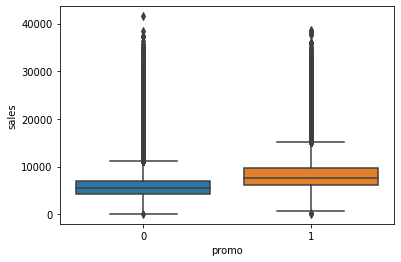

In [ ]:
sns.boxplot(x='promo', y='sales', data=df_2)

In [ ]:
# Promoção parece não fazer efeito

# Receita média das vendas sem promoção é maior do que em promoção

df_2[['is_promo','sales']].groupby('is_promo').mean()

,sales
is_promo,
0,7052.209581
1,6492.563338


In [ ]:
# Porém a mediana das vendas sem promoção é parecida do que em promoção

df_2[['is_promo','sales']].groupby('is_promo').median()

,sales
is_promo,
0,6440.0
1,6045.0


In [ ]:
# Promoção 2 parece não fazer efeito

# Média

df_2[['promo2','sales']].groupby('promo2').mean()

,sales
promo2,
0,7350.818414
1,6558.993542


In [ ]:
# Mediana

df_2[['promo2','sales']].groupby('promo2').median()

,sales
promo2,
0,6685.0
1,6075.0
